# Social networks
Overall project objective was as follows: <b>"Causes of youth violent crime in London: Are opinions on its causes as expressed on Twitter more closely aligned with the ‘facts’, or with the social network to which a tweeter belongs."</b> What we want to assess in this notebook is whether tweeters with the same opinions cluster in the same social groups.




Previously we analysed Twitter data to understand 'WHAT' was being discussed about serious violent crime on Twitter and used that to predict whether the opinion expressed within tweets was 'AGAINST' or 'NOT AGAINST' the causes given by the Mayor. We then used that data to infer the opinion of Twitter users ('tweeters') based on the aggregate opinion expressed across all their tweets.

In this notebook we focus on the 'WHO', which is the communities that are discussing crime and the key influencers within these communities. Having identified these communities we can then see whether there is a relationship between the previsouly derived tweeter opinions and the communities to which they belong. Performing this analysis helps us answer the our second of our research questions, namely: can we identify the social groups to which users rejecting the Mayor’s evidence belong, and whether this view is widely spread within those groups?

Furthermore, performing this comparison also helps us to answer our first research question, which was "Can Twitter sentiment analysis determine the proportions of Twitter users that accept or reject the London Mayor’s evidence that ‘deprivation in the leading cause of youth violent crime in London’?" 


- this is a useful link for academic backup for making the comparison between topic and comminuty https://www.jmir.org/2016/8/e232

Unfortunately, we know the predictive capability is only moderate and the classifier produces quite different results to those we get by manually annotating. However, it is too soon to automatically conclude that it is therefore a poor predictor of tweeter opinion. This is because tweeter opinion is formed by aggregating opinions across all the tweeter's individual tweets and in aggregate form the weight of these tweets might lead to a better predictor of Tweeter opinion. While counterintuitive, this is a key principle in big data mining wherein advocates such as Anand Rajaraman present empirical evidence which suggests more data usually beats better algorithms [5]. The 'usually' is the important factor here, and we will specifically test for this in our next notebook where will will deduce whether the tweeters holding predicted opinions are clustered within similar communities.


We have a body of tweets from which we can understand who is communication with who and by extension which communities exist within our body of tweeters. We also have a set of tweeter screen names, labeled to express whether they hold an opinion 'AGAINST' or 'NOT AGAINST' the London Mayor on the causes of crime. 

## Context




### Network components
Connected components are a subset of nodes in which each node has a minimum of one link with another node in the same subset, and any node that is a member of 'this' subset is not linked to any nodes external to the subset. 

In addition, for <b> directed </b> graphs we can define two types of connected components:
- Weakly connected components, (WCC): maximal set of nodes where there exists a path in at least one direction between each pair of nodes.
- Strongly connected components, (SCC): maximal set of nodes where there exists a path in both directions between each pair of nodes.

And, within these categories we can additionally identify the weakly connected giant (WCGC), which is the largest of the weakly connected components and the strongly connected giant (SCGC), which is the largest of the strongly connected components. In effect these are the largest subgraphs within the network. Bovet et al illustrate this (incorrectly, for SCGC given arrows aren't two way) as follows:

<img src="WCGC-SCGC.png">


we were going to do membership over time but that was on the expectation we could get twitter data spanning 2 years. We don't believe this is beneficial given we only have data for 1 month.

Add as a conclusion:
Strongly connected networks are two way conversations but previously we saw 75% of tweets were retweets and so this suggests the networks are far more one way and so that's why we get more useful results using weakly connected networks.



I basically use two sources for this, Bovet and programminghistorian

What I want to find out is basically the following:
1. Are there obvious social clusters within our network
2. If so, how big are they and how strong are the relationships
3. Within these networks, who are the most important tweeters

We also want to know the following general information:
- Which users are most important, irrespective of network

## Changes I need to make
- Bring strong connections up front - say not really informative but keep an eye out for key players
- Then do overview of degrees and centrality - explain why
- Get components + communities
- Do page ranking - explain why and compare with degrees

In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
all_tweets = pd.read_csv("./DataSources/TwitterData/cleaned_tweets.csv")

In [3]:
print("shape before after dropping rows with all NaN")
print(all_tweets.shape)
all_tweets = all_tweets.dropna(how='all') # only drops a row when every column is NA

print(all_tweets.shape)

# Now check for individual NaN values
nan_values = all_tweets[all_tweets.isna().any(axis=1)]
print(nan_values.count())

shape before after dropping rows with all NaN
(41706, 26)
(41706, 26)
index                           41651
tweet_id                        41651
tweet_date                      41651
tweeter_id                      41651
tweeter_user_name               41651
tweeter_screen_name             41651
tweeter_location                41651
message_text                    41651
in_reply_to_user_screen_name     4607
quote_tweet_screen_name           747
favourite_count                 41651
retweet_count                   41651
is_retweet                      41651
extract_run_date                41651
retrieved_using_search_term     41651
retweeted                       41651
mentioned                       41651
hashtags                        41651
Tweet_punct                     41651
Tweet_tokenized                 41651
Tweet_nonstop                   41651
Tweet_lemmatized                41651
Clean_MessageText               41610
tweet_date_dt                   41651
time_bins_12h     

#### Comments
- Set null values in_reply_to_user_screen_name and quote_tweet_screen_name fields to blanks because it's reasonable to have nothing in these fields
- We know from prior notebooks that some tweets have null clean message text and so just set to blanks as we aren't looking at message text in this notebook

In [4]:
all_tweets.loc[all_tweets['in_reply_to_user_screen_name'].isna(), 'in_reply_to_user_screen_name'] = ''
all_tweets.loc[all_tweets['quote_tweet_screen_name'].isna(), 'quote_tweet_screen_name'] = ''
all_tweets.loc[all_tweets['Clean_MessageText'].isna(), 'Clean_MessageText'] = ''

# Now check for individual NaN values
nan_values = all_tweets[all_tweets.isna().any(axis=1)]

nan_values.head()

Empty DataFrame
Columns: [index, tweet_id, tweet_date, tweeter_id, tweeter_user_name, tweeter_screen_name, tweeter_location, message_text, in_reply_to_user_screen_name, quote_tweet_screen_name, favourite_count, retweet_count, is_retweet, extract_run_date, retrieved_using_search_term, retweeted, mentioned, hashtags, Tweet_punct, Tweet_tokenized, Tweet_nonstop, Tweet_lemmatized, Clean_MessageText, tweet_date_dt, time_bins_12h, day_bins]
Index: []

[0 rows x 26 columns]

## Build interaction network
There are four primary ways in which Twitter users interact: reply to, mention, retweet and quote tweet and we will create a body of interaction from our tweet dataset and use this to create our interation network. In this network, the tweeter will be vertices and the interaction between them will be the edges. Previously, when building our hashtag network, we used bespoke code to derive the strength on the edges by summing the number of times it occured. In this case we will use functions available within NetworkX to achieve the same goal.

What we are trying to 


### This code draws heavily on the work of Bovet
### https://github.com/alexbovet/network_lesson/blob/master/02_Analysis_of_Twitter_Social_Network.ipynb

We will use the python module NetworkX to construct and analyze the social network.

There are four types of interactions between two users in Twitter:
- Retweet
- Quote
- Reply
- Mention

In [5]:
# let's define some functions to extract the interactions from tweets
def string_to_list(my_str):
    delimiter = ","
    my_str = my_str.replace("[", "")
    my_str = my_str.replace("]", "")
    my_str = my_str.replace("@", "")
    my_str = my_str.replace("'", "")
    my_str = my_str.replace(" ", "")
    my_list = my_str.split(delimiter)
    return my_list

def getAllInteractions(tweet):
    
    # Get the tweeter
    tweet_id = tweet.tweet_id
    tweeter_id = tweet.tweeter_id
    tweeter_name = tweet.tweeter_screen_name
    
    # a python set is a collection of unique items
    # we use a set to avoid duplicated ids
    interacting_users = set()
    
    # Add person they're replying to
    if tweet.in_reply_to_user_screen_name != '':
        interacting_users.add(tweet.in_reply_to_user_screen_name)
        
    # Add person they quoted
    if tweet.quote_tweet_screen_name != '':
        interacting_users.add(tweet.quote_tweet_screen_name)
    
    # Add person they retweeted
    if len(tweet.retweeted) > 2: # because empty strings will contain []
        retweeted_list = string_to_list(tweet.retweeted)
        for item in retweeted_list:
            interacting_users.add(item)
       
    # Add mentions
    if len(tweet.mentioned) > 2: # because empty strings will contain []
        mentioned_list = string_to_list(tweet.mentioned)
        for item in mentioned_list:
            interacting_users.add(item)
  
    # remove the tweeter if he is in the set
    interacting_users.discard(tweeter_name)
    
    # Return our tweeter and their influencers
    return tweeter_id, tweeter_name, tweet_id, list(interacting_users)

In [6]:
import networkx as nx

# define an empty Directed Graph
# A directed graph is a graph where edges have a direction
# in our case the edges goes from user that sent the tweet to
# the user with whom they interacted (retweeted, mentioned or quoted)
G = nx.DiGraph()

# I need create a list of all interacting users for later
# this is because we know we have tweeters who have been retweeted but
# haven't tweeted themselves - this is a gap in our opinion labelling
# which we address later
all_interacting_users = []

for index, tweet in all_tweets.iterrows():
    
    if (tweet.tweeter_screen_name != 'SadiqKhan') & (tweet.tweeter_screen_name != 'MayorofLondon'):
        tweeter_id, tweeter_name, tweet_id, interactions = getAllInteractions(tweet)
        
        all_interacting_users.extend(interactions)
    
        # add an edge to the Graph for each influencer
        for interact_name in interactions:
        
            # add edges between the two user ids
            # this will create new nodes if the nodes are not already in the network
            # we also add an attribute the to edge equal to the id of the tweet
            G.add_edge(tweeter_name, interact_name, tweet_id=tweet_id)
        
            # add name as a property to each node
            # with networkX each node is a dictionary
            G.nodes[tweeter_name]['name'] = tweeter_name
            G.nodes[interact_name]['name'] = interact_name
            
            
all_interacting_users_set = set(all_interacting_users)

## Start with network characteristics
Based on tutorial from: https://programminghistorian.org/en/lessons/exploring-and-analyzing-network-data-with-python 
- John R. Ladd, Jessica Otis, Christopher N. Warren, and Scott Weingart, "Exploring and Analyzing Network Data with Python," The Programming Historian 6 (2017), https://doi.org/10.46430/phen0064.

In [54]:
print("Number of unique tweeters: {:,}\n".format(all_tweets.tweeter_screen_name.nunique()))

print(nx.info(G))

Number of unique tweeters: 23,857

Name: 
Type: DiGraph
Number of nodes: 26523
Number of edges: 43031
Average in degree:   1.6224
Average out degree:   1.6224


#### Comments
Note the difference between the number of unique tweeters and the number of nodes created (one node for each tweeter screen name). This difference arises from interactions with tweeters (e.g. retweets) for whom we don't have the original tweet as it was tweeted prior to our data capture date.

In [8]:
# On a scale of 0 to 1, where 1 is a dense network
density = nx.density(G)
print("Network density:", density)

Network density: 6.117197787591622e-05


In [9]:
degree_dict = dict(G.degree(G.nodes()))
nx.set_node_attributes(G, degree_dict, 'degree')

In [10]:
# the keys are the user_id
nodelist = list(G.nodes.keys())
print(nodelist[:10])

['myerschrismyer1', 'LeslieH24367191', 'emilysheffield', 'NaheedMajeed', 'standardnews', 'basilewitch', 'Short2Cjs', 'DeanCowcher', 'sonya_annie', 'OliverSteinme16']


In [11]:
# each node is itself a dictionary with node attributes as key,value pairs
print(type(G.nodes[nodelist[3]]))
print(G.nodes[nodelist[3]])

<class 'dict'>
{'name': 'NaheedMajeed', 'degree': 6}


In [12]:
from operator import itemgetter
from networkx.algorithms import community 

sorted_degree = sorted(degree_dict.items(), key=itemgetter(1), reverse=True)

In [13]:
print("Top 20 nodes by degree:")
for d in sorted_degree[:20]:
    print(d)

Top 20 nodes by degree:
('SadiqKhan', 1296)
('MayorofLondon', 933)
('KoolKat1025', 912)
('GBNEWS', 875)
('James_Thorburn', 871)
('NKrankie', 742)
('LeaveEUOfficial', 737)
('LeoKearse', 635)
('LeslieH24367191', 575)
('MartinDaubney', 532)
('standardnews', 522)
('polblonde', 489)
('metpoliceuk', 471)
('LozzaFox', 446)
('BrexitBassist', 433)
('NormanBrennan', 397)
('MickeyD44314901', 390)
('Independent', 377)
('PoliticsForAlI', 365)
('PoliticsJOE_UK', 321)


In [14]:
betweenness_dict = nx.betweenness_centrality(G) # Run betweenness centrality
eigenvector_dict = nx.eigenvector_centrality(G) # Run eigenvector centrality

# Assign each to an attribute in your network
nx.set_node_attributes(G, betweenness_dict, 'betweenness')
nx.set_node_attributes(G, eigenvector_dict, 'eigenvector')

In [15]:
sorted_betweenness = sorted(betweenness_dict.items(), key=itemgetter(1), reverse=True)

print("Top 20 nodes by betweenness centrality:")
for b in sorted_betweenness[:20]:
    print(b)

Top 20 nodes by betweenness centrality:
('James_Thorburn', 0.00040829501837604746)
('LeslieH24367191', 0.0003547568289868739)
('MickeyD44314901', 0.00023596962431397727)
('Simon_S70', 0.0001915142180710078)
('suemitch2017', 0.00018900059400466578)
('LSadler16861851', 0.00012912684611349665)
('KingBobIIV', 0.00012332620786912316)
('kakiOwakagirl', 0.000108503704615942)
('SilvertownTn', 9.915109609466635e-05)
('simon4124', 8.736642712729378e-05)
('NormanBrennan', 8.726378756912479e-05)
('telesyros', 7.754835224629279e-05)
('TflTruth', 7.654660656436779e-05)
('taxi_leaks', 7.25995016606247e-05)
('Stan_VoWales', 7.005567634729698e-05)
('GarySuter5', 6.102455006655463e-05)
('TX4Silver', 6.03682883035982e-05)
('PaulCra33107260', 5.928704101098548e-05)
('ossien1', 5.609751616259887e-05)
('DonnachadhMc', 5.207822738441689e-05)


In [16]:
#First get the top 20 nodes by betweenness as a list
top_betweenness = sorted_betweenness[:20]

#Then find and print their degree
for tb in top_betweenness: # Loop through top_betweenness
    degree = degree_dict[tb[0]] # Use degree_dict to access a node's degree, see footnote 2
    print("Name:", tb[0], "| Betweenness Centrality:", tb[1], "| Degree:", degree)

Name: James_Thorburn | Betweenness Centrality: 0.00040829501837604746 | Degree: 871
Name: LeslieH24367191 | Betweenness Centrality: 0.0003547568289868739 | Degree: 575
Name: MickeyD44314901 | Betweenness Centrality: 0.00023596962431397727 | Degree: 390
Name: Simon_S70 | Betweenness Centrality: 0.0001915142180710078 | Degree: 98
Name: suemitch2017 | Betweenness Centrality: 0.00018900059400466578 | Degree: 122
Name: LSadler16861851 | Betweenness Centrality: 0.00012912684611349665 | Degree: 18
Name: KingBobIIV | Betweenness Centrality: 0.00012332620786912316 | Degree: 121
Name: kakiOwakagirl | Betweenness Centrality: 0.000108503704615942 | Degree: 6
Name: SilvertownTn | Betweenness Centrality: 9.915109609466635e-05 | Degree: 149
Name: simon4124 | Betweenness Centrality: 8.736642712729378e-05 | Degree: 177
Name: NormanBrennan | Betweenness Centrality: 8.726378756912479e-05 | Degree: 397
Name: telesyros | Betweenness Centrality: 7.754835224629279e-05 | Degree: 40
Name: TflTruth | Betweennes

### Load tweeter opinions and add to network as a node attribute

In [17]:
labeled_users = pd.read_csv('./DataSources/TwitterData/labeled_users.csv')
print(labeled_users.shape)
labeled_users.head()

(23108, 5)


tweeter_screen_name  AGAINST  FOR  NOT_AGAINST tweeter_label
0          0007_vishi      1.0  0.0          0.0       AGAINST
1              005e5n      0.0  0.0          1.0   NOT_AGAINST
2          007AJSmith      1.0  0.0          1.0   NOT_AGAINST
3             007dmax      0.0  0.0          1.0   NOT_AGAINST
4             007taff      1.0  0.0          0.0       AGAINST

In [18]:
unique_tweeters = all_tweets.tweeter_screen_name.unique()

unique_tweeters_df = pd.DataFrame(unique_tweeters, columns =['tweeter_screen_name'])

all_tweeters = pd.merge(unique_tweeters_df, labeled_users, how='left', left_on='tweeter_screen_name', 
                        right_on='tweeter_screen_name')

all_tweeters.loc[all_tweeters['tweeter_label'].isna(), 'tweeter_label'] = 'NONE'

display(all_tweeters.shape)
all_tweeters.tweeter_label.unique()

(23857, 5)

array(['NOT_AGAINST', 'AGAINST', 'NONE', 'FOR'], dtype=object)

### Labeling tweeters who haven't tweeted but were retweeted
We have an issue becayse we have approximately 4,500 tweeters who have been retweeted but for whom we do not have original tweets in our dataset and so we could not assign an opinion to them. Previously we created 'all_interacting_users_set' and now we use that as the basis for identifying users that were retweeted but didn't tweet, so that we can then review and asign them labels

In [19]:
unique_tweeters_set = set(unique_tweeters)
print("Number of tweeters who have tweeted at least once: {:,}".format(len(unique_tweeters)))
print("Number of tweeters who haven't been retweeted: {:,}".format(len(unique_tweeters_set.difference(all_interacting_users_set))))

retweeted_not_tweeted = all_interacting_users_set.difference(unique_tweeters_set)
print("Number of tweeters who have been retweeted but haven't tweeted: {:,}".format(len(retweeted_not_tweeted)))

retweeted_not_tweeted_list = list(retweeted_not_tweeted)

df_all_interacting_users = pd.DataFrame(all_interacting_users, columns=['tweeter_screen_name'])

Number of tweeters who have tweeted at least once: 23,857
Number of tweeters who haven't been retweeted: 21,164
Number of tweeters who have been retweeted but haven't tweeted: 4,424


In [20]:
df_all_interacting_users_agg = df_all_interacting_users.groupby(["tweeter_screen_name"]).apply(lambda x: x['tweeter_screen_name'].count()).reset_index()
df_all_interacting_users_agg.rename(columns = {0:'count'}, inplace = True)

df_all_interacting_users_agg.sort_values(by='count', ascending=False)[:10]

tweeter_screen_name  count
3507           SadiqKhan   1548
2625       MayorofLondon   1167
1467              GBNEWS   1013
2292     LeaveEUOfficial    921
2200         KoolKat1025    913
2818            NKrankie    906
1918      James_Thorburn    855
6685        standardnews    639
2309           LeoKearse    637
2315     LeslieH24367191    597

In [21]:
df_retweeted_not_tweeted = pd.DataFrame(retweeted_not_tweeted_list, columns=['tweeter_screen_name'])

df_retweeted_not_tweeted_counts = pd.merge(df_retweeted_not_tweeted, df_all_interacting_users_agg, 
                                           how='inner', left_on='tweeter_screen_name', right_on='tweeter_screen_name')

df_retweeted_not_tweeted_counts.sort_values(by='count', ascending=False)[:20]


tweeter_screen_name  count
3351        Keir_Starmer    198
1767        BorisJohnson    183
3734           PolBlonde    170
3375     aceattorneygame    157
3515          pritipatel    134
4131               Denis    108
2426       JeremyVineOn5    108
4111           telegraph     97
1579             YouTube     62
2885              TfLTPH     58
623       CraigMurrayOrg     58
3342        NewsForAllUK     55
905        RichardBurgon     45
3095         MetPoliceUK     41
1569       doctor_oxford     37
1661       HackneyAbbott     37
520      edmundmlawrence     37
2688           AlexScott     36
3803          sajidjavid     35
862            mrjamesob     34

#### Comments
The subset of users aren't among those who've been retweeted the most (e.g. MayorOfLondon retweeted 1,548 vs Keir_Starmer retweeted 198 times) and, of this smaller group, many of those who were retweeted most often are public figures and so just set their opinion to 'NONE' i.e. neutral. We do run the risk of mis labeling some users who've been retweeted but, for the reasons we've just laid out, we don't believe this will be material.

In [22]:
df_retweeted_not_tweeted['tweeter_label'] = 'NONE'
retweeted_not_tweeted_dict = dict(zip(df_retweeted_not_tweeted.tweeter_screen_name,df_retweeted_not_tweeted.tweeter_label))

opinions_dict = dict(zip(all_tweeters.tweeter_screen_name,all_tweeters.tweeter_label))

In [23]:
# taken from https://www.geeksforgeeks.org/python-merging-two-dictionaries/
def Merge(dict1, dict2):
    res = {**dict1, **dict2}
    return res


combined_opinions_dict = Merge(opinions_dict, retweeted_not_tweeted_dict)
len(combined_opinions_dict), len(opinions_dict), len(retweeted_not_tweeted_dict)



(28281, 23857, 4424)

In [24]:
# Assign each to an attribute in the network
nx.set_node_attributes(G, combined_opinions_dict, 'opinions')

## Connected components

### Strongly connected components

In [25]:
# this returns a list of set of nodes belonging to the 
# different (strongly) connected components
components_strong = list(nx.strongly_connected_components(G))

# sort the component according to their size
components_strong = list(sorted(components_strong, key=lambda x:len(x), reverse=True))

# make a list with the size of each component
comp_sizes_strong = []
for comp in components_strong:
    comp_sizes_strong.append(len(comp))
    
print("number of strong components: {}".format(len(comp_sizes_strong)))

print("sizes of the ten largest components: {}".format(comp_sizes_strong[:20]))

number of strong components: 26168
sizes of the ten largest components: [31, 22, 12, 11, 10, 6, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 3]


In [26]:
from itertools import count

def draw_strongly_connected(idx, components_strong):

    largest_comp_strong = components_strong[idx]
    LCC_strong = G.subgraph(largest_comp_strong)
    
    # now set colors
    opinions = set(nx.get_node_attributes(LCC_strong,'opinions').values())
    mapping = dict(zip(sorted(opinions),count()))
    
    nodes = LCC_strong.nodes()
    colors = [mapping[LCC_strong.nodes[n]['opinions']] for n in nodes]
    
    print("number of components in LCC[{}] = {}".format(idx, LCC_strong.number_of_nodes()))

    # let's plot the degree distribution inside the LCC
    degrees = [LCC_strong.degree(n) for n in LCC_strong.nodes()]
    print("number of degrees for each node within LCC[{}] = {}\n".format(idx, degrees))
       
    ## <--- now look at centrality
    betweenValues = nx.betweenness_centrality(LCC_strong)
    
    # betweenValues is a dictionary, let's get the values and keys in separate lists
    values = list(betweenValues.values())
    keys = list(betweenValues.keys())
    
    # find the index of the node with highest betweeness centrality
    highestIndex = np.argmax(values)
    
    #Uses solution in the documentation: https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.components.connected.connected_component_subgraphs.html
    
    print('\n <---- centrality and clustering measures -------> \n')
    print("The node id ", keys[highestIndex], " has the centrality degree of ", values[highestIndex])  
    
    pos = nx.spring_layout(LCC_strong)
    
    plt.figure()
    plt.axis('off')

    nx.draw_networkx(LCC_strong, pos, nodelist=nodes, node_color=colors, 
                            with_labels=False, node_size=300, cmap=plt.cm.jet)
    plt.show()

number of components in LCC[0] = 31
number of degrees for each node within LCC[0] = [4, 2, 2, 11, 3, 3, 2, 3, 2, 3, 2, 4, 3, 4, 2, 5, 6, 8, 3, 3, 6, 3, 12, 2, 3, 11, 7, 3, 2, 2, 4]


 <---- centrality and clustering measures -------> 

The node id  Simon_S70  has the centrality degree of  0.578735632183908


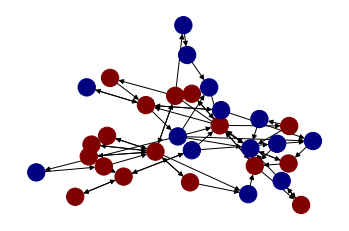

number of components in LCC[1] = 22
number of degrees for each node within LCC[1] = [4, 4, 4, 3, 9, 6, 5, 10, 3, 6, 9, 2, 9, 5, 2, 7, 5, 4, 5, 3, 8, 7]


 <---- centrality and clustering measures -------> 

The node id  telesyros  has the centrality degree of  0.5281746031746032


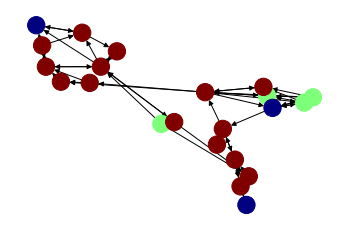

number of components in LCC[2] = 12
number of degrees for each node within LCC[2] = [6, 6, 2, 7, 5, 6, 2, 3, 4, 6, 4, 3]


 <---- centrality and clustering measures -------> 

The node id  OnLondon  has the centrality degree of  0.7272727272727273


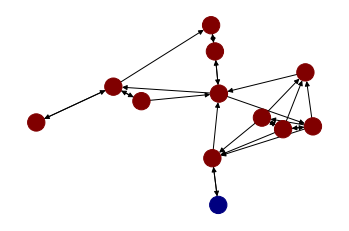

number of components in LCC[3] = 11
number of degrees for each node within LCC[3] = [6, 10, 15, 17, 7, 11, 15, 14, 14, 6, 7]


 <---- centrality and clustering measures -------> 

The node id  Dryadula  has the centrality degree of  0.23148148148148148


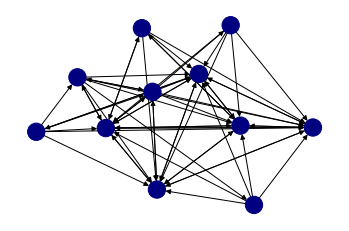

number of components in LCC[4] = 10
number of degrees for each node within LCC[4] = [3, 2, 4, 3, 15, 5, 4, 5, 2, 3]


 <---- centrality and clustering measures -------> 

The node id  SilvertownTn  has the centrality degree of  0.8402777777777777


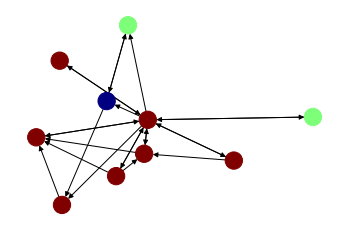

In [27]:
# now set colors
#opinions = set(nx.get_node_attributes(G,'opinions').values())
#mapping = dict(zip(sorted(opinions),count()))

range_limit = 5
for n in range(range_limit):
    draw_strongly_connected(n, components_strong)

### Weakly connected components

In [28]:
#1.  this returns a list of set of nodes belonging to the 
# different (weakly) connected components
components = list(nx.weakly_connected_components(G))

# sort the component according to their size
components = list(sorted(components, key=lambda x:len(x), reverse=True))

In [29]:
components_dict = {} # Create a blank dictionary
for i,c in enumerate(components): # Loop through the list of communities, keeping track of the number for the community
    for name in c: # Loop through each person in a community
        components_dict[name] = i # Create an entry in the dictionary for the person, where the value is which group they belong to.

# Now you can add modularity information like we did the other metrics
nx.set_node_attributes(G, components_dict, 'weak_component_id')

In [30]:
df_components_dict = pd.DataFrame(list(components_dict.items()),columns = ['screen_name','weak_comp_class_id']) 
comp_class_list = df_components_dict.weak_comp_class_id.unique()

print("Number of different weak components = {} ".format(len(comp_class_list)))

display(df_components_dict.tail())

df_components_dict_agg = df_components_dict.groupby('weak_comp_class_id').count()

comm_count = 10
print("\nTop {} components, by number of members".format(comm_count))
df_components_dict_agg.head(comm_count)

Number of different weak components = 1535 


screen_name  weak_comp_class_id
26518      ZG1999_                1532
26519  Mikey_Lloyd                1533
26520  bestcanton7                1533
26521    TheDazeel                1534
26522    Helexzura                1534


Top 10 components, by number of members


screen_name
weak_comp_class_id             
0                         20801
1                           165
2                           163
3                           125
4                            83
5                            43
6                            41
7                            40
8                            36
9                            31

In [31]:
#2. make a list with the size of each component
comp_sizes = []
for comp in components:
    comp_sizes.append(len(comp))

In [32]:
def color_lookup(color_key, mapping):
    label = mapping[color_key]
    return label

def display_weak_components(n, components, G):
    # let's make a new graph which is the subgraph of G corresponding to index=n
    
    print("\n<------------- subcomponent: {} --------------->\n".format(n))
    
    
    # First get a list of just the nodes in that class
    comp_id = [i for i in G.nodes() if G.nodes[i]['weak_component_id'] == n]

    # Then create a dictionary of the eigenvector centralities of those nodes
    comp_eigenvector = {n:G.nodes[n]['eigenvector'] for n in comp_id}
    
    print(len(comp_eigenvector))

    # Then sort that dictionary and print the first 5 results
    print_count=5
    comp_sorted_by_eigenvector = sorted(comp_eigenvector.items(), key=itemgetter(1), reverse=True)

    print("\n<--- Modularity Class {} Sorted by Eigenvector Centrality, top {} values --->".format(n, print_count))
    for node in comp_sorted_by_eigenvector[:print_count]:
        print("Name:", node[0], "| Eigenvector Centrality:", node[1])

    largest_comp = components[n]
    LCC = G.subgraph(largest_comp)  
    
    print("Number of nodes in current subcomponent: {:,}".format(LCC.number_of_nodes()))
        
    # now set colors
    opinions = set(nx.get_node_attributes(LCC,'opinions').values())
    mapping = dict(zip(sorted(opinions),count()))
    
    nodes = LCC.nodes()
    colors = [mapping[LCC.nodes[n]['opinions']] for n in nodes]
    
    colors_df = pd.DataFrame(colors, columns=['color'])
    colors_agg_df = colors_df.groupby(["color"]).apply(lambda x: x['color'].count()).reset_index()
    colors_agg_df.rename(columns = {0:'count'}, inplace = True)
    
    # need to swap keys and values - https://www.geeksforgeeks.org/python-program-to-swap-keys-and-values-in-dictionary/
    new_mapping = dict([(value, key) for key, value in mapping.items()])
       
    colors_agg_df['label'] = ''
    colors_agg_df['label'] = colors_agg_df.apply(lambda x: color_lookup(x['color'], new_mapping), axis=1)
    
    display(colors_agg_df[['label', 'count']].sort_values(by='count', ascending=False))
        
    if n > 0:
        
        pos = nx.spring_layout(LCC)
    
        plt.figure(figsize=(15,15))
        plt.axis('off')
        nx.draw_networkx(LCC, pos, nodelist=nodes, node_color=colors, 
                            with_labels=False, node_size=300, cmap=plt.cm.jet)
        plt.show()


<------------- subcomponent: 0 --------------->

20801

<--- Modularity Class 0 Sorted by Eigenvector Centrality, top 5 values --->
Name: SadiqKhan | Eigenvector Centrality: 0.002051289860778871
Name: MayorofLondon | Eigenvector Centrality: 0.0010847851983536122
Name: dotmit | Eigenvector Centrality: 0.001003261095789305
Name: delgueg | Eigenvector Centrality: 0.001003261095789305
Name: PaulCra33107260 | Eigenvector Centrality: 0.0007923785516019609
Number of nodes in current subcomponent: 20,801


label  count
3  NOT_AGAINST  11092
0      AGAINST   7127
2         NONE   2578
1          FOR      4


<------------- subcomponent: 1 --------------->

165

<--- Modularity Class 1 Sorted by Eigenvector Centrality, top 5 values --->
Name: m_ontatta20 | Eigenvector Centrality: 8.69502762932017e-16
Name: Taehyung_india_ | Eigenvector Centrality: 1.4514577519439036e-16
Name: alsaad_fofo | Eigenvector Centrality: 2.7437764687030304e-19
Name: TashmiAmadi | Eigenvector Centrality: 2.7437764687030304e-19
Name: MuskanP25267761 | Eigenvector Centrality: 2.7437764687030304e-19
Number of nodes in current subcomponent: 165


label  count
0  AGAINST    165

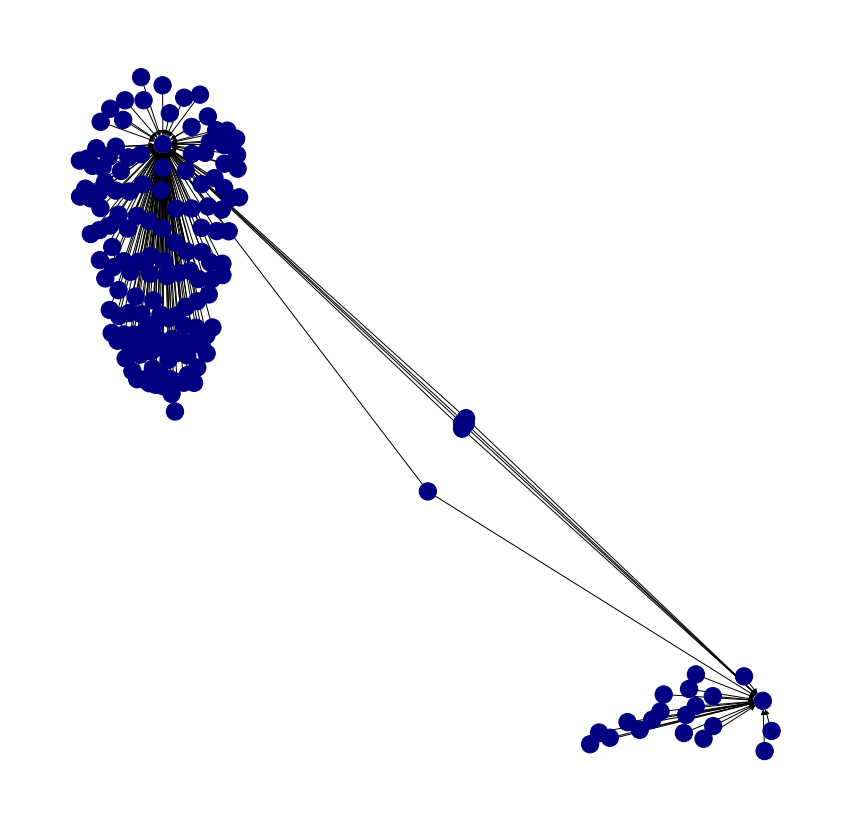


<------------- subcomponent: 2 --------------->

163

<--- Modularity Class 2 Sorted by Eigenvector Centrality, top 5 values --->
Name: KeshooBai | Eigenvector Centrality: 1.1713181744893342e-15
Name: DRMAHREENBHUTTO | Eigenvector Centrality: 1.4514577519439036e-16
Name: Khalid_Munir | Eigenvector Centrality: 7.271007642063021e-17
Name: drafaquepsf | Eigenvector Centrality: 3.6492227033750284e-17
Name: syedOwais01 | Eigenvector Centrality: 2.7437764687030304e-19
Number of nodes in current subcomponent: 163


label  count
2  NOT_AGAINST    135
0      AGAINST     17
1         NONE     11

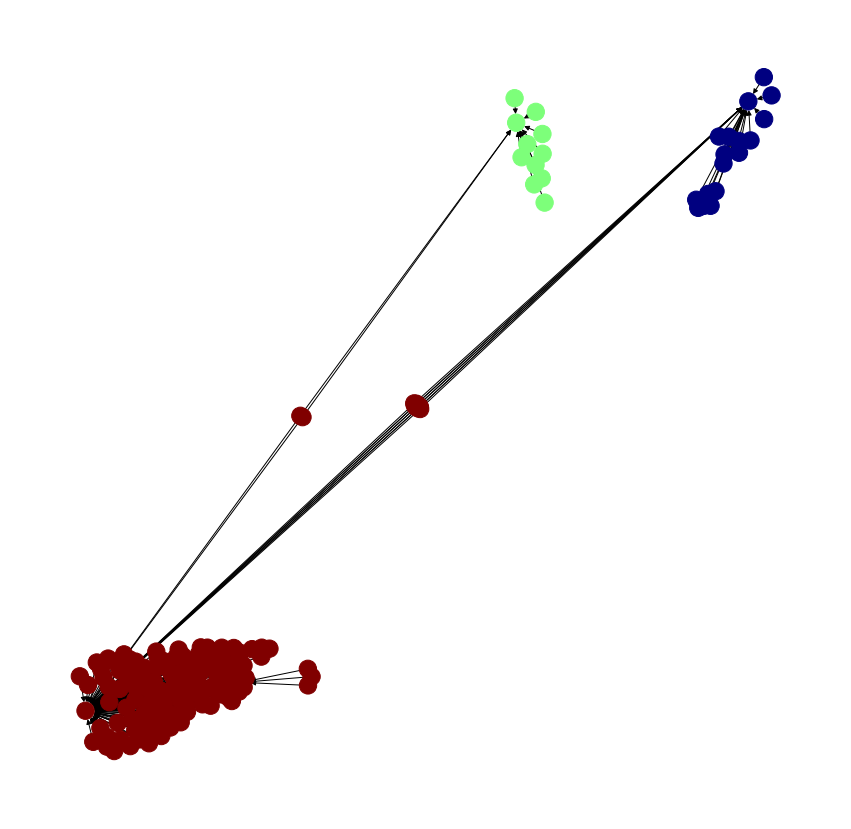


<------------- subcomponent: 3 --------------->

125

<--- Modularity Class 3 Sorted by Eigenvector Centrality, top 5 values --->
Name: aceattorneygame | Eigenvector Centrality: 7.487765983090817e-16
Name: BY0SUke | Eigenvector Centrality: 2.7437764687030304e-19
Name: swagtastic326 | Eigenvector Centrality: 2.7437764687030304e-19
Name: basefjodryan | Eigenvector Centrality: 2.7437764687030304e-19
Name: RubyFighter16 | Eigenvector Centrality: 2.7437764687030304e-19
Number of nodes in current subcomponent: 125


label  count
1  NOT_AGAINST    122
0         NONE      3

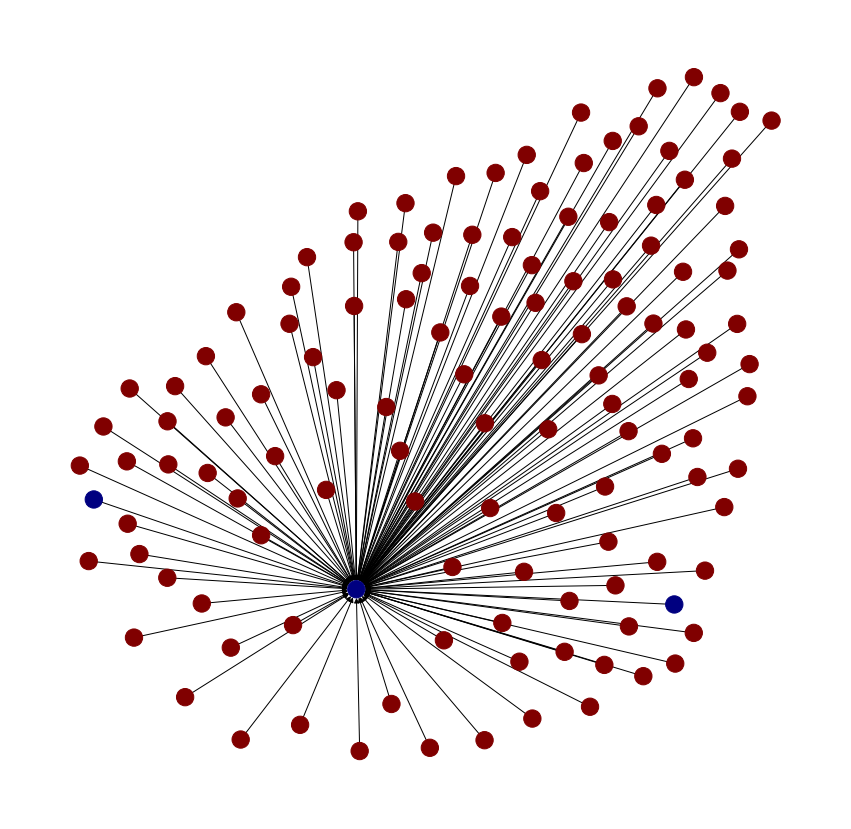


<------------- subcomponent: 4 --------------->

83

<--- Modularity Class 4 Sorted by Eigenvector Centrality, top 5 values --->
Name: maximka2 | Eigenvector Centrality: 1.4942606648556718e-15
Name: Chilegals | Eigenvector Centrality: 1.8136362458126996e-16
Name: Lyndarenham | Eigenvector Centrality: 1.5118208342553707e-16
Name: JohnMeadAuthor | Eigenvector Centrality: 1.3910946696324403e-16
Name: James49story | Eigenvector Centrality: 2.441961057145698e-17
Number of nodes in current subcomponent: 83


label  count
2  NOT_AGAINST     49
0      AGAINST     20
1         NONE     14

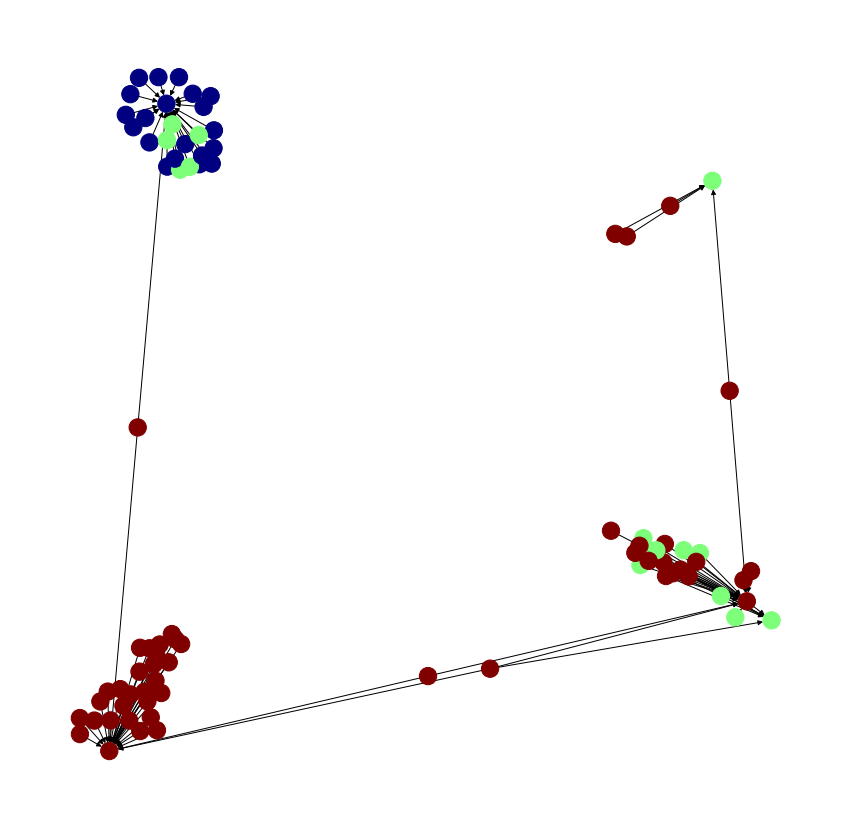


<------------- subcomponent: 5 --------------->

43

<--- Modularity Class 5 Sorted by Eigenvector Centrality, top 5 values --->
Name: ImranKhanPTI | Eigenvector Centrality: 1.904180869279902e-16
Name: Jemima_Khan | Eigenvector Centrality: 8.478269288292361e-17
Name: murtazasolangi | Eigenvector Centrality: 7.271007642063021e-17
Name: QureshiAsadAli | Eigenvector Centrality: 6.667376818948358e-17
Name: m__dutt | Eigenvector Centrality: 6.667376818948358e-17
Number of nodes in current subcomponent: 43


label  count
1         NONE     16
2  NOT_AGAINST     15
0      AGAINST     12

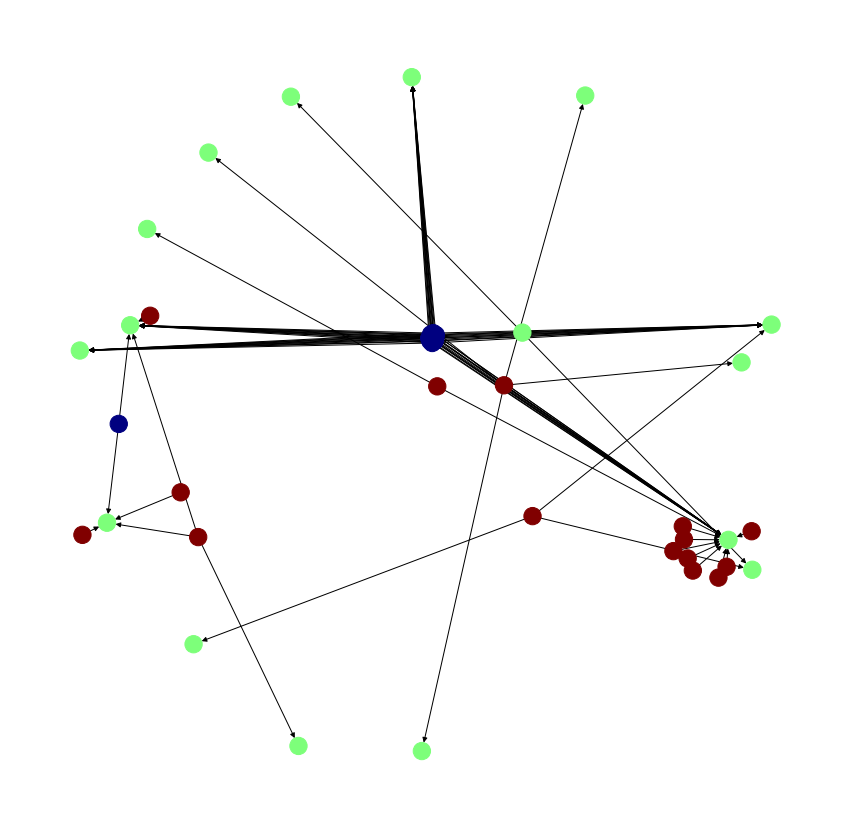

In [33]:
my_range = range(0, 6) # n.b. 0 is too large so takes too long to display

for n in my_range:
    display_weak_components(n, components, G)

## Community detection

In [34]:
H = nx.Graph(G) # need to convert to undirected graph to use greedy_modularity

communities = community.greedy_modularity_communities(H)

In [35]:
modularity_dict = {} # Create a blank dictionary
for i,c in enumerate(communities): # Loop through the list of communities, keeping track of the number for the community
    for name in c: # Loop through each person in a community
        modularity_dict[name] = i # Create an entry in the dictionary for the person, where the value is which group they belong to.

# Now you can add modularity information like we did the other metrics
nx.set_node_attributes(G, modularity_dict, 'modularity')

In [36]:
df_community_dict = pd.DataFrame(list(modularity_dict.items()),columns = ['screen_name','class_id']) 
class_list = df_community_dict.class_id.unique()

print("Number of different communities = {} ".format(len(class_list)))

df_community_dict_agg = df_community_dict.groupby('class_id').count()

comm_count = 14
print("\nTop {} communities, by number of members".format(comm_count))
df_community_dict_agg.head(comm_count)

Number of different communities = 1669 

Top 14 communities, by number of members


screen_name
class_id             
0                5213
1                3742
2                1624
3                1019
4                1011
5                 782
6                 662
7                 647
8                 540
9                 520
10                506
11                448
12                427
13                359

In [37]:
from matplotlib import pyplot as plt
    
def print_class_members(class_num, count, mapping):

    # First get a list of just the nodes in that class
    class_id = [n for n in G.nodes() if G.nodes[n]['modularity'] == class_num]

    # Then create a dictionary of the eigenvector centralities of those nodes
    class_eigenvector = {n:G.nodes[n]['eigenvector'] for n in class_id}

    # Then sort that dictionary and print the first 5 results
    class_sorted_by_eigenvector = sorted(class_eigenvector.items(), key=itemgetter(1), reverse=True)

    print("\n<--- Modularity Class {} Sorted by Eigenvector Centrality, top {} values --->".format(class_num, count))
    for node in class_sorted_by_eigenvector[:count]:
        print("Name:", node[0], "| Eigenvector Centrality:", node[1])
        
    my_subgraph = G.subgraph(class_id)
    
    # now set colors
    nodes = my_subgraph.nodes()
    colors = [mapping[my_subgraph.nodes[n]['opinions']] for n in nodes]
    
    colors_df = pd.DataFrame(colors, columns=['color'])
    colors_agg_df = colors_df.groupby(["color"]).apply(lambda x: x['color'].count()).reset_index()
    colors_agg_df.rename(columns = {0:'count'}, inplace = True)
    
    # need to swap keys and values - https://www.geeksforgeeks.org/python-program-to-swap-keys-and-values-in-dictionary/
    new_mapping = dict([(value, key) for key, value in mapping.items()])
       
    colors_agg_df['label'] = ''
    colors_agg_df['label'] = colors_agg_df.apply(lambda x: color_lookup(x['color'], new_mapping), axis=1)
    
    display(colors_agg_df[['label', 'count']].sort_values(by='count', ascending=False))
    
    pos = nx.spring_layout(my_subgraph)
    
    plt.figure(figsize=(20,20))
    plt.axis('off')
    nx.draw_networkx(my_subgraph, pos, nodelist=nodes, node_color=colors, 
                            with_labels=False, node_size=300, cmap=plt.cm.jet)
    plt.show()


### Compare with classes allocated via labeled tweets

In [38]:
print(df_community_dict.shape)
df_community_dict.head()

(26523, 2)


screen_name  class_id
0  JenShaw60301596         0
1   JesusCoucheiro         0
2  cinzanocoiffeur         0
3  jackiem29967594         0
4  Kennedy25405368         0

In [39]:
merged_df = pd.merge(labeled_users, df_community_dict, left_on='tweeter_screen_name', right_on='screen_name')
print(merged_df.shape)

(21452, 7)


In [40]:
just_against = merged_df[merged_df.tweeter_label=='AGAINST'].copy()
against_count = just_against.shape[0]
print(just_against.shape)
just_against.head()

(8101, 7)


tweeter_screen_name  AGAINST  FOR  NOT_AGAINST tweeter_label  screen_name  \
0          0007_vishi      1.0  0.0          0.0       AGAINST   0007_vishi   
4             007taff      1.0  0.0          0.0       AGAINST      007taff   
6         02031961pat      6.0  0.0          2.0       AGAINST  02031961pat   
7           0606Green      6.0  0.0          2.0       AGAINST    0606Green   
9           07706Mike      2.0  0.0          1.0       AGAINST    07706Mike   

   class_id  
0        18  
4         5  
6         0  
7         0  
9         0

In [41]:
just_against_sorted = just_against[['AGAINST','class_id']].groupby(['class_id'])['AGAINST'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False) 

just_against_sorted['class_pct_of_total'] = just_against_sorted['count'] / against_count

just_against_sorted.reset_index().head(20)

index  class_id  count  class_pct_of_total
0       0         0   2875            0.354894
1       1         1    690            0.085175
2       9         9    451            0.055672
3       5         5    409            0.050488
4       2         2    387            0.047772
5      13        13    261            0.032218
6       4         4    242            0.029873
7      11        11    194            0.023948
8      15        15    186            0.022960
9      18        18    165            0.020368
10      6         6    146            0.018022
11      8         8    138            0.017035
12      3         3    121            0.014936
13     10        10    114            0.014072
14     16        16    113            0.013949
15      7         7     86            0.010616
16     24        25     76            0.009382
17     23        24     72            0.008888
18     25        26     65            0.008024
19     22        22     62            0.007653

### Comments
We have 5,011 in combined dataframe and approximately 75% of these fall into the classes: 0, 1, 9, 5, 2, 13, 4, 11, 15, 18 and 6

Now we take a look at these classes to see their membership and whether they correlate.

n.b. group by logic above courtesy of https://stackoverflow.com/questions/40454030/count-and-sort-with-pandas

<----- class 0 ----->

<--- Modularity Class 0 Sorted by Eigenvector Centrality, top 10 values --->
Name: LeaveEUOfficial | Eigenvector Centrality: 0.00042193601937126087
Name: MickeyD44314901 | Eigenvector Centrality: 0.0003815273361234546
Name: NKrankie | Eigenvector Centrality: 0.00034516763409579037
Name: LeslieH24367191 | Eigenvector Centrality: 0.0003202487691128607
Name: James_Thorburn | Eigenvector Centrality: 0.0003018538345979437
Name: KhanMustGo | Eigenvector Centrality: 0.0002535147552989485
Name: telegraph | Eigenvector Centrality: 0.00022814657864916155
Name: HarrietSergeant | Eigenvector Centrality: 0.00022329136712941593
Name: NormanBrennan | Eigenvector Centrality: 0.00021956932625420784
Name: suemitch2017 | Eigenvector Centrality: 0.00021016151541037307


label  count
0      AGAINST   2875
3  NOT_AGAINST   2121
2         NONE    215
1          FOR      2

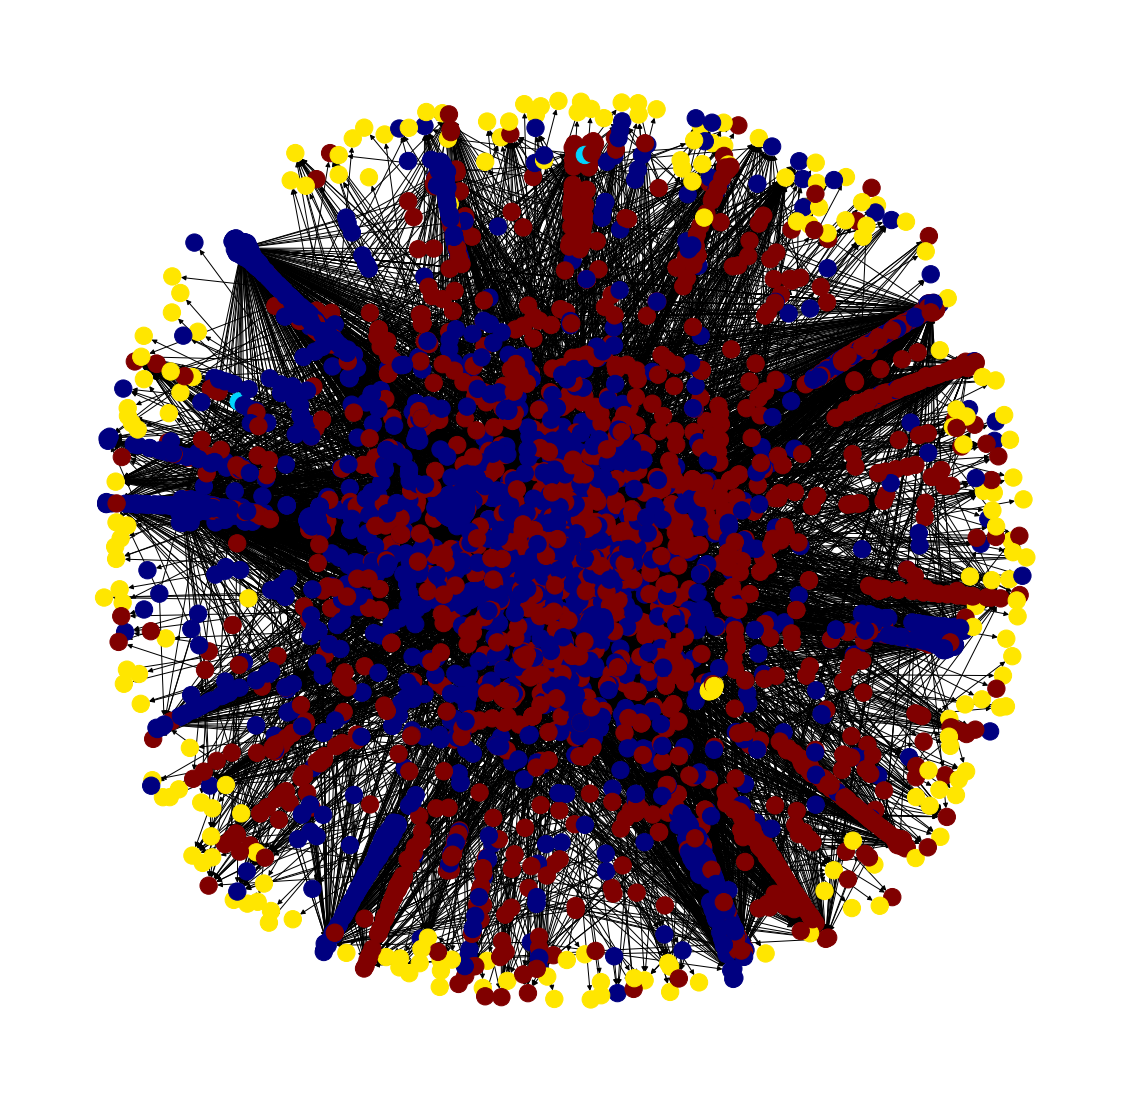

<----- class 1 ----->

<--- Modularity Class 1 Sorted by Eigenvector Centrality, top 10 values --->
Name: SadiqKhan | Eigenvector Centrality: 0.002051289860778871
Name: MayorofLondon | Eigenvector Centrality: 0.0010847851983536122
Name: dotmit | Eigenvector Centrality: 0.001003261095789305
Name: delgueg | Eigenvector Centrality: 0.001003261095789305
Name: PaulCra33107260 | Eigenvector Centrality: 0.0007923785516019609
Name: LornaBlane | Eigenvector Centrality: 0.0007923785516019609
Name: Ryu79726178 | Eigenvector Centrality: 0.0007923785516019603
Name: arben_sallaku | Eigenvector Centrality: 0.0007480525549432023
Name: JohnieClayton_ | Eigenvector Centrality: 0.000625822004086432
Name: sowthewind1 | Eigenvector Centrality: 0.000625822004086432


label  count
3  NOT_AGAINST   2469
0      AGAINST    690
2         NONE    582
1          FOR      1

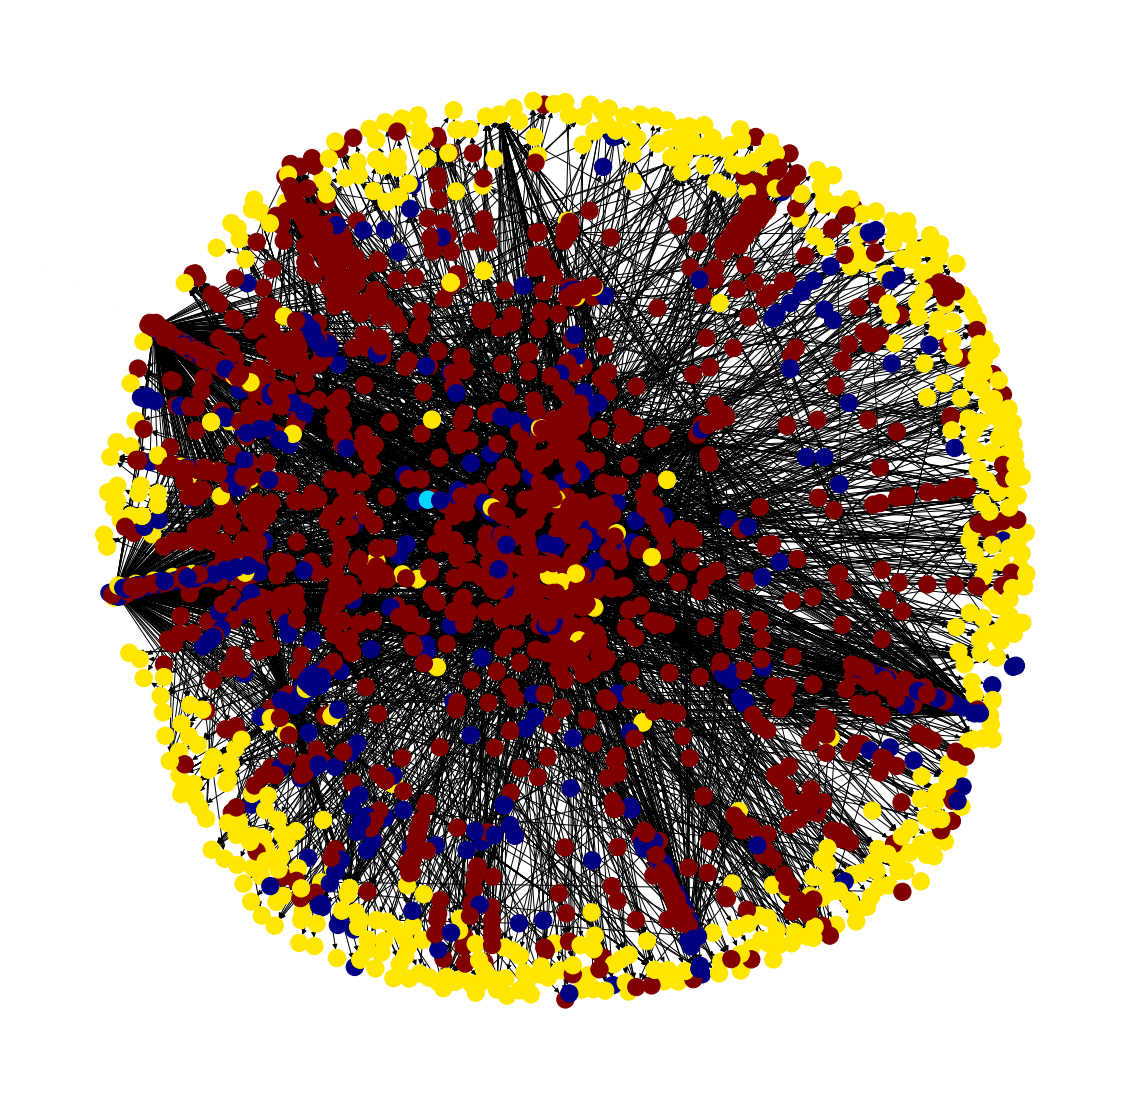

<----- class 9 ----->

<--- Modularity Class 9 Sorted by Eigenvector Centrality, top 10 values --->
Name: LeoKearse | Eigenvector Centrality: 1.4221616936690198e-06
Name: BStardAlan | Eigenvector Centrality: 1.2645441343041288e-10
Name: Stonesologist_ | Eigenvector Centrality: 1.0086044595202747e-10
Name: icecoldjayrod1 | Eigenvector Centrality: 1.0086044595202747e-10
Name: maxwell_marlow | Eigenvector Centrality: 1.1508230148388177e-11
Name: SaveVTG | Eigenvector Centrality: 1.1508230148388177e-11
Name: KatySei | Eigenvector Centrality: 1.1508232617786995e-12
Name: leedsforbritain | Eigenvector Centrality: 1.1508232617786995e-12
Name: 27476b54549e462 | Eigenvector Centrality: 1.96454395159137e-16
Name: CalamityClaire4 | Eigenvector Centrality: 8.176453876735034e-17


label  count
0      AGAINST    451
2  NOT_AGAINST     56
1         NONE     13

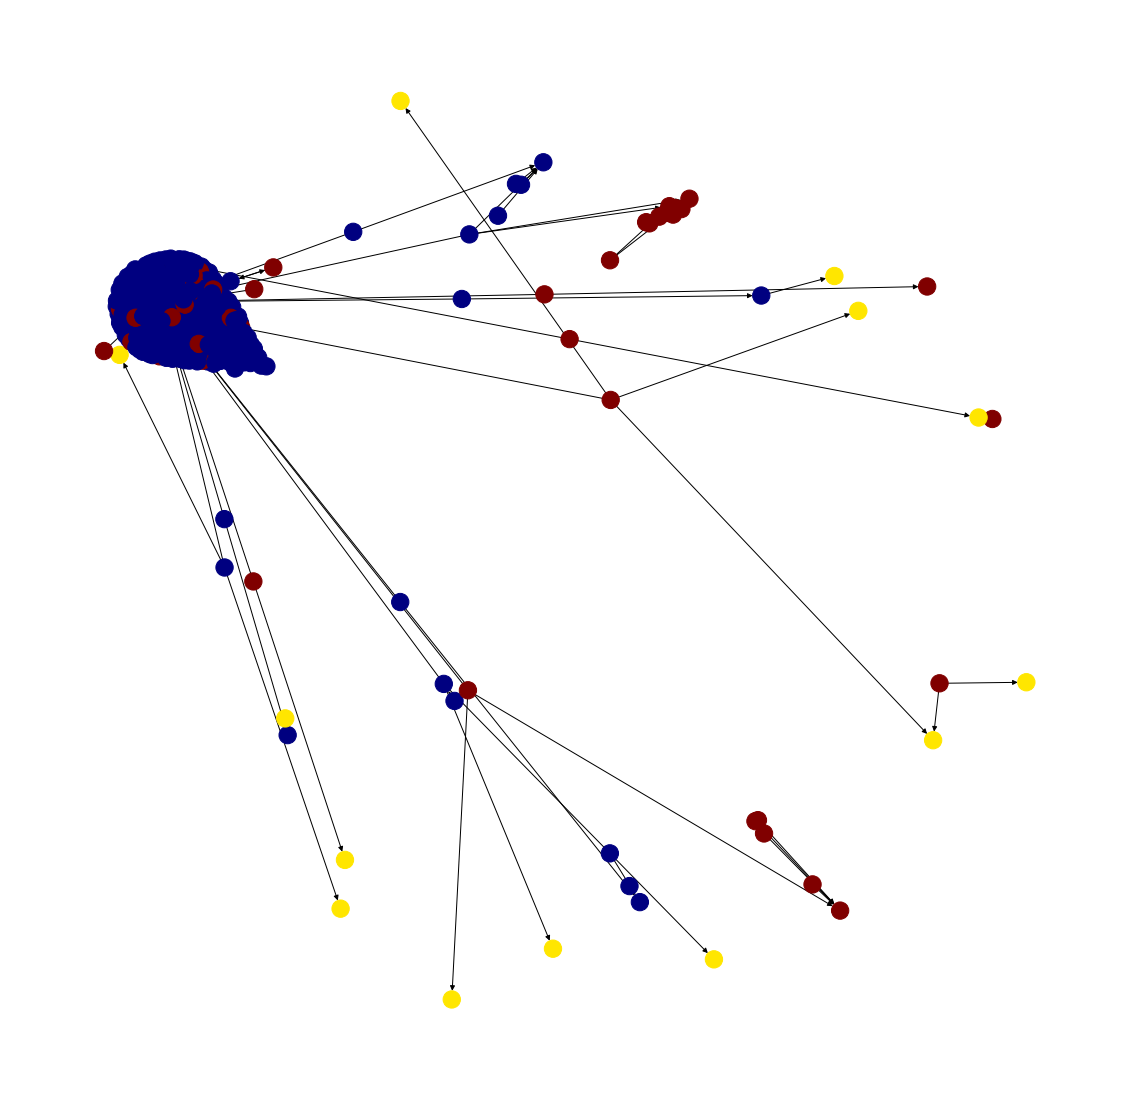

<----- class 5 ----->

<--- Modularity Class 5 Sorted by Eigenvector Centrality, top 10 values --->
Name: GBNEWS | Eigenvector Centrality: 0.0004682949408909766
Name: linmeitalks | Eigenvector Centrality: 7.173494887518954e-06
Name: LisaMil36579884 | Eigenvector Centrality: 4.442446596892637e-06
Name: VRnews101 | Eigenvector Centrality: 4.035223719669562e-06
Name: Timmy200012 | Eigenvector Centrality: 4.035223719669562e-06
Name: ZSocials | Eigenvector Centrality: 2.9845312526509303e-06
Name: Miss_Snuffy | Eigenvector Centrality: 2.1145289714151846e-06
Name: Alexwhatdaa | Eigenvector Centrality: 2.114528971225041e-06
Name: OhHeWentThere | Eigenvector Centrality: 1.563946933046839e-06
Name: _AngloMatt | Eigenvector Centrality: 1.563946933046839e-06


label  count
0      AGAINST    409
2  NOT_AGAINST    277
1         NONE     96

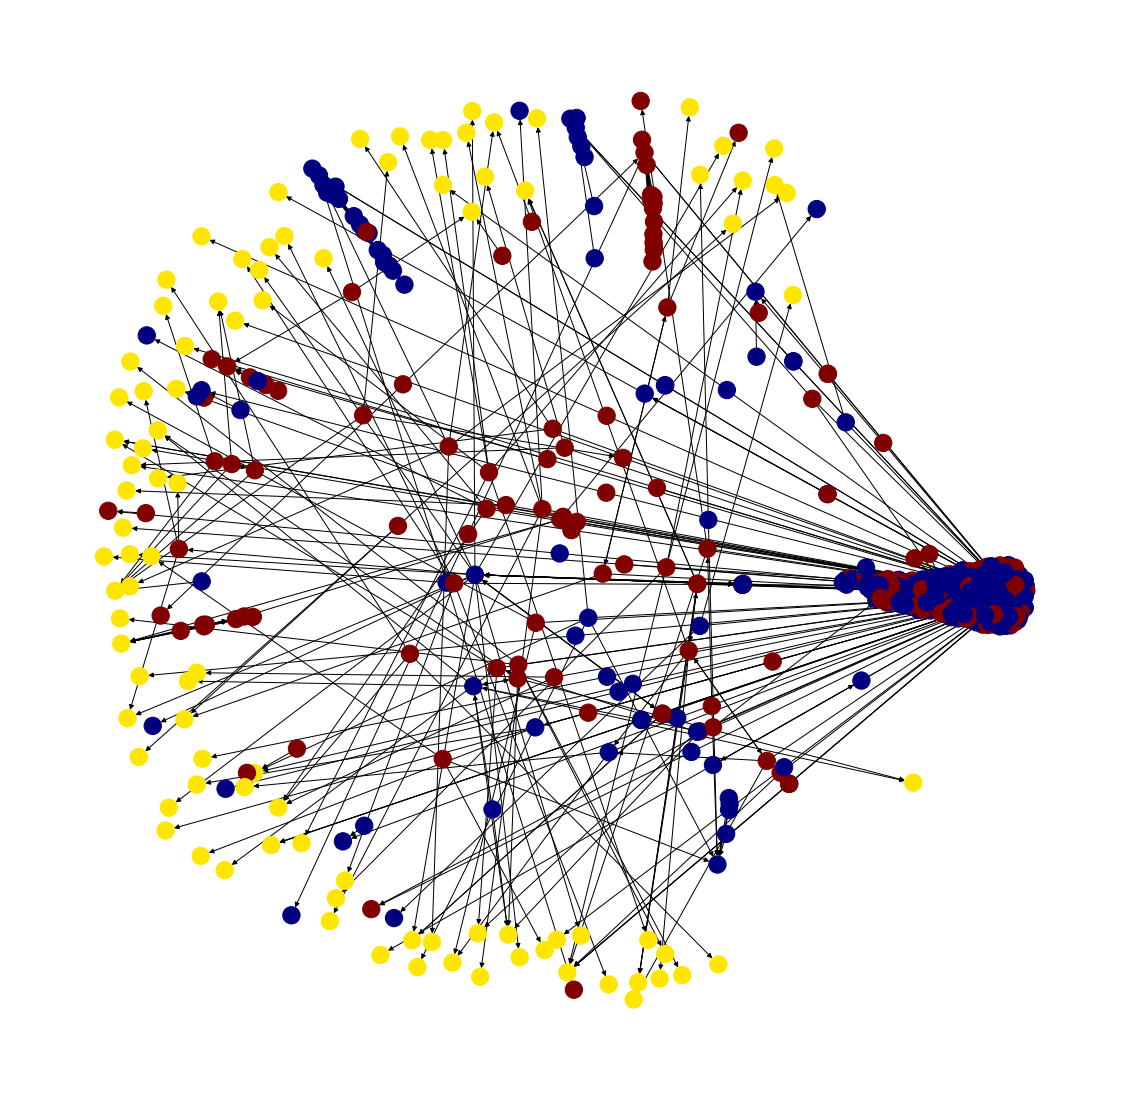

<----- class 2 ----->

<--- Modularity Class 2 Sorted by Eigenvector Centrality, top 10 values --->
Name: talkRADIO | Eigenvector Centrality: 0.0002325172042839162
Name: LozzaFox | Eigenvector Centrality: 0.00018250200158155156
Name: thereclaimparty | Eigenvector Centrality: 0.00014839445773497445
Name: darrengrimes_ | Eigenvector Centrality: 0.0001386139403696416
Name: JeremyVineOn5 | Eigenvector Centrality: 0.00011431293171824699
Name: Iromg | Eigenvector Centrality: 9.36790986396845e-05
Name: MartinDaubney | Eigenvector Centrality: 9.251343151652679e-05
Name: inshorts | Eigenvector Centrality: 6.371728422219638e-05
Name: valseeseveryone | Eigenvector Centrality: 4.973273078982002e-05
Name: ClarkeMicah | Eigenvector Centrality: 4.1483718786584265e-05


label  count
2  NOT_AGAINST   1078
0      AGAINST    387
1         NONE    159

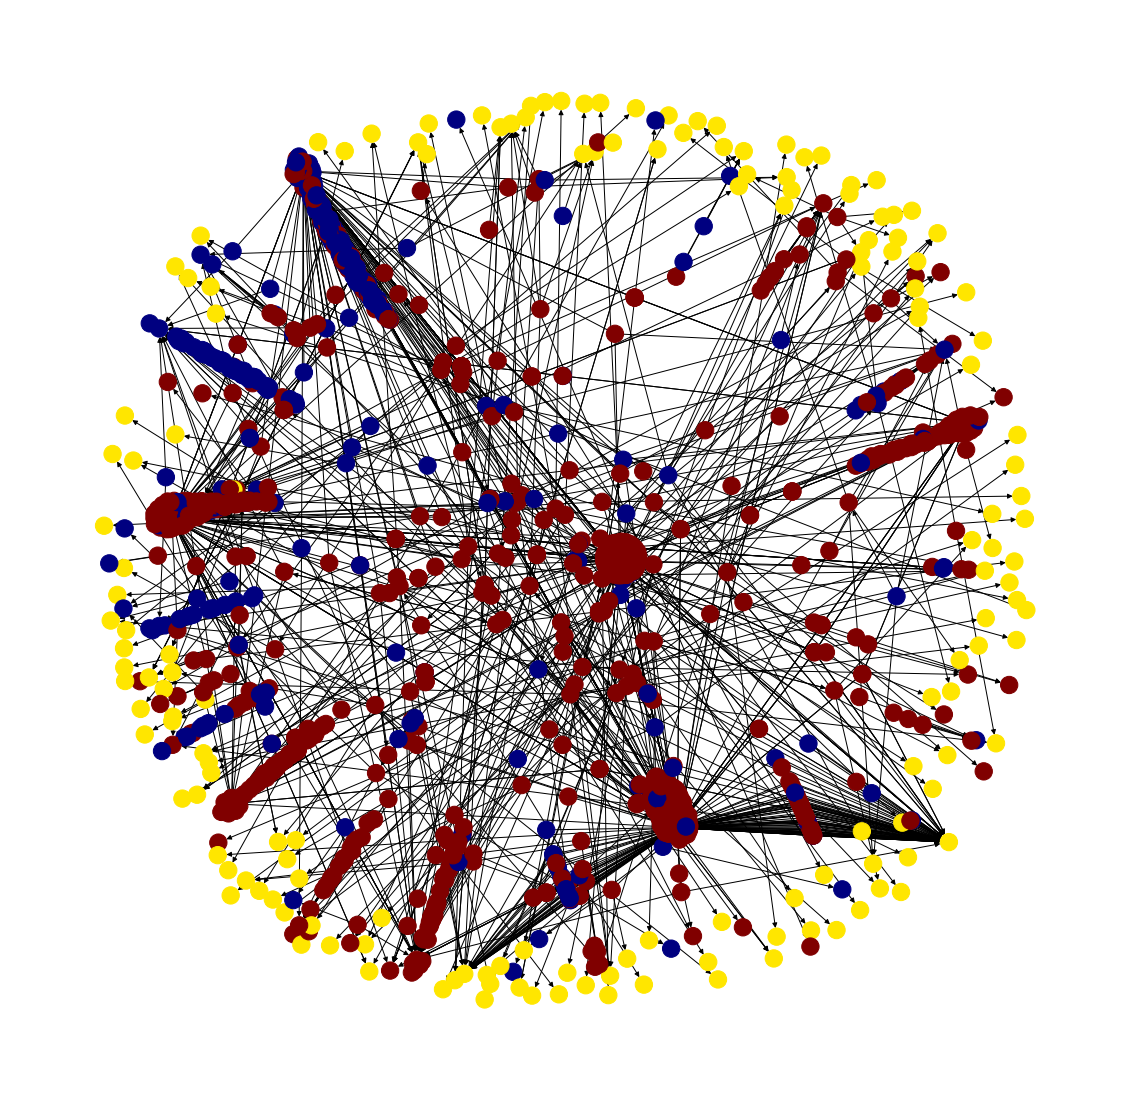

<----- class 13 ----->

<--- Modularity Class 13 Sorted by Eigenvector Centrality, top 10 values --->
Name: MirrorPolitics | Eigenvector Centrality: 1.3984590642809913e-05
Name: mariannaspring | Eigenvector Centrality: 6.612202322202682e-10
Name: gordonblackburn | Eigenvector Centrality: 6.837397699045782e-11
Name: NiceMangos | Eigenvector Centrality: 6.189959713394037e-16
Name: tovers98 | Eigenvector Centrality: 1.0892792580751042e-16
Name: netpol | Eigenvector Centrality: 8.780084699849698e-17
Name: oilpaintwitch | Eigenvector Centrality: 8.780084699849696e-17
Name: Saffiya_Khan1 | Eigenvector Centrality: 8.176453876735034e-17
Name: GhalibMK | Eigenvector Centrality: 6.969192230505697e-17
Name: CharlotteBellis | Eigenvector Centrality: 6.969192230505697e-17


label  count
0      AGAINST    261
2  NOT_AGAINST     77
1         NONE     21

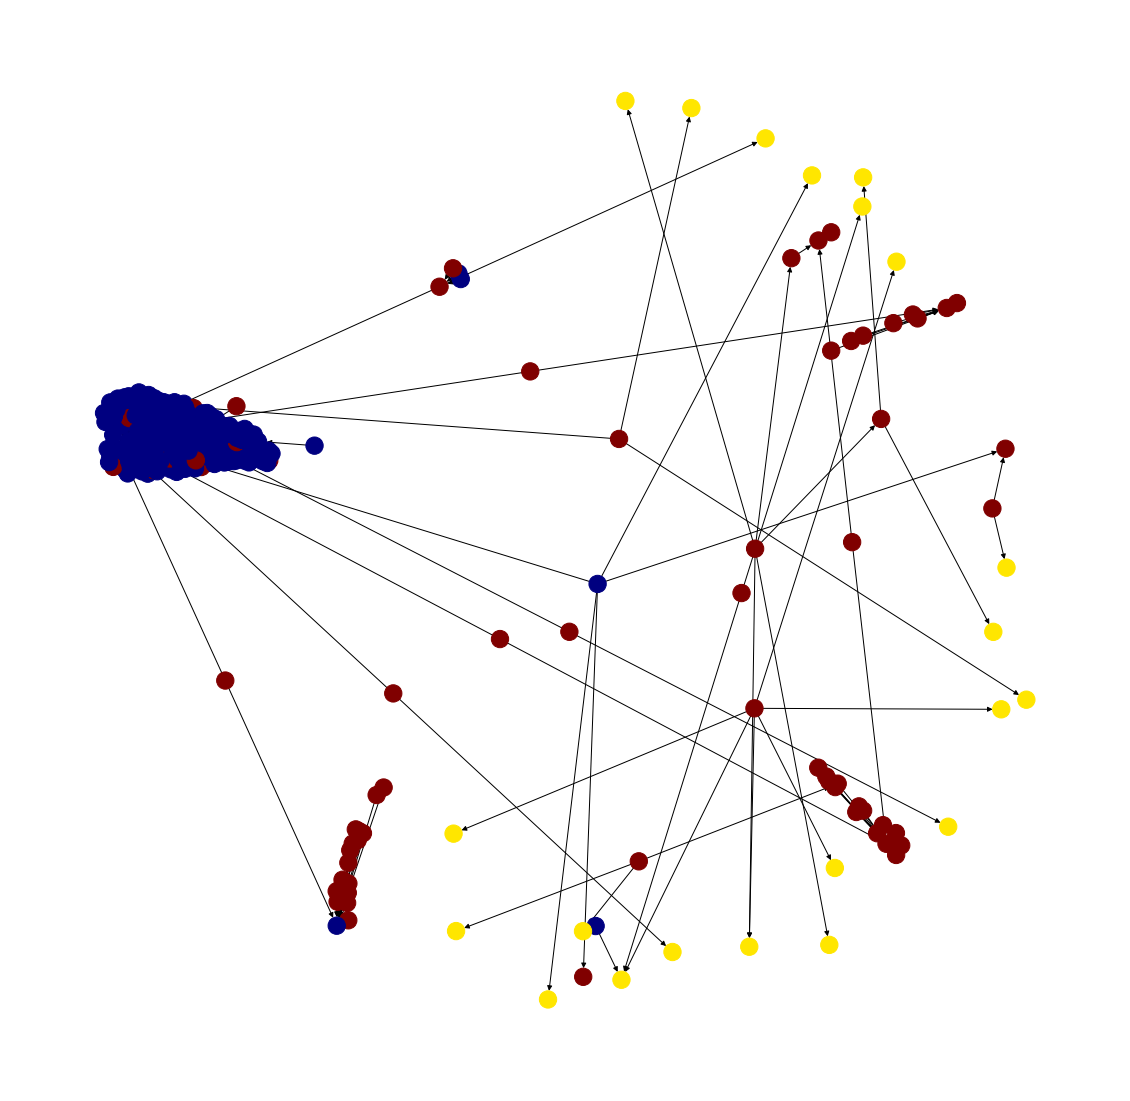

<----- class 4 ----->

<--- Modularity Class 4 Sorted by Eigenvector Centrality, top 10 values --->
Name: CrimeLdn | Eigenvector Centrality: 0.00015657468471570775
Name: OwenJones84 | Eigenvector Centrality: 4.973273079033011e-05
Name: hewitson111 | Eigenvector Centrality: 5.136016745472447e-06
Name: PoliticsForAlI | Eigenvector Centrality: 4.061907853408882e-08
Name: KalDore87 | Eigenvector Centrality: 2.7576617163383788e-08
Name: Independent | Eigenvector Centrality: 1.9652205226937364e-08
Name: talkSPORT | Eigenvector Centrality: 2.8115636177574697e-09
Name: LizabethAnne32 | Eigenvector Centrality: 2.0182841024213953e-09
Name: Marg__Anne | Eigenvector Centrality: 2.0182841024213953e-09
Name: ScottieHammer1 | Eigenvector Centrality: 1.878672105389712e-09


label  count
2  NOT_AGAINST    670
0      AGAINST    242
1         NONE     99

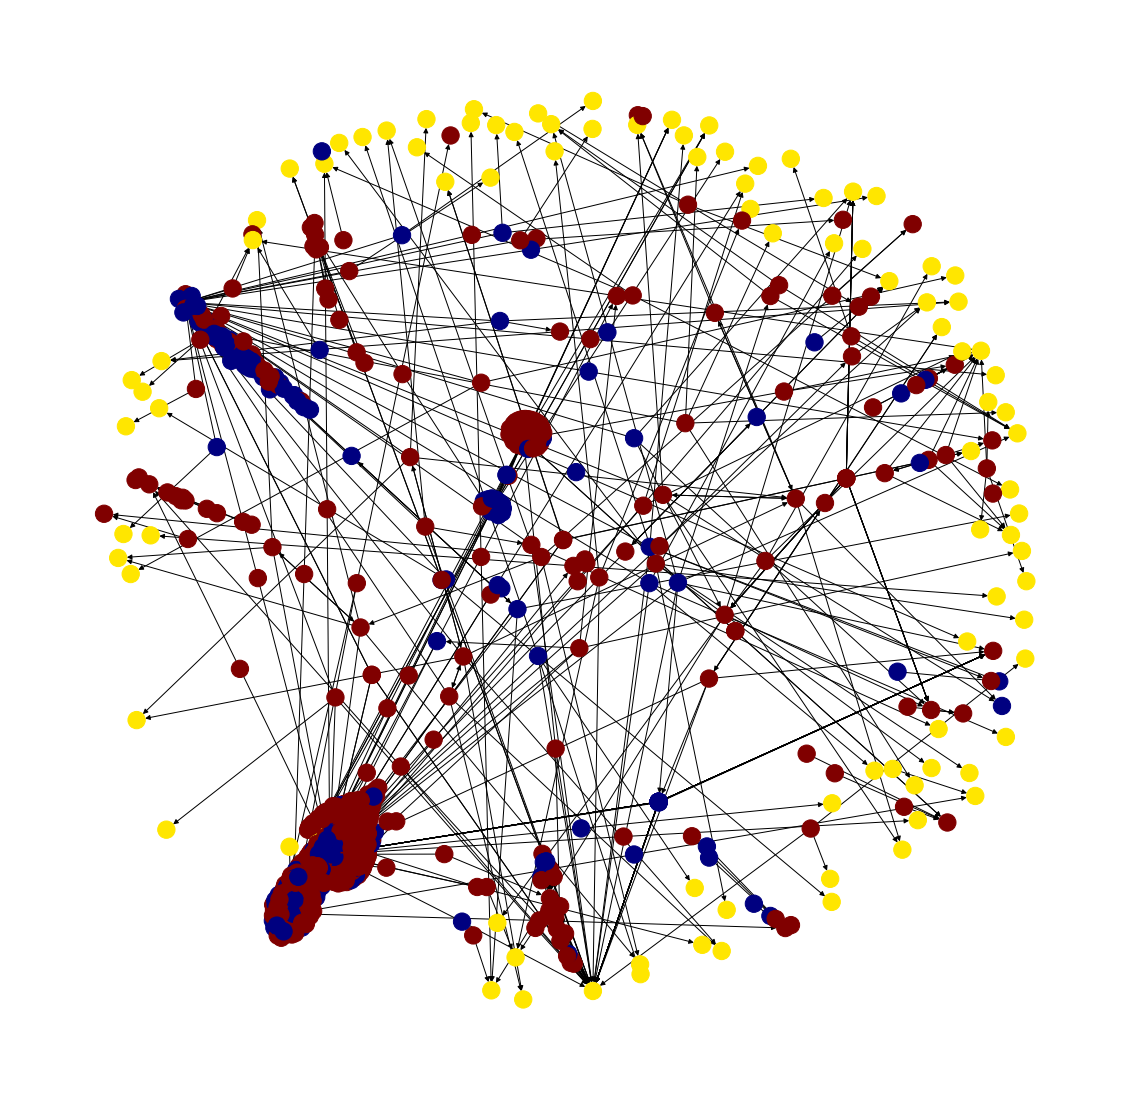

<----- class 11 ----->

<--- Modularity Class 11 Sorted by Eigenvector Centrality, top 10 values --->
Name: martinsross1 | Eigenvector Centrality: 6.796736451348646e-06
Name: AyoCaesar | Eigenvector Centrality: 2.3854756881168094e-06
Name: Harshbutfairy | Eigenvector Centrality: 1.563946933046839e-06
Name: Stanly2N | Eigenvector Centrality: 8.426082972949286e-07
Name: michaeljswalker | Eigenvector Centrality: 5.505820381784763e-07
Name: RedRhinoStudio | Eigenvector Centrality: 5.505820381724401e-07
Name: hindmost_ | Eigenvector Centrality: 5.505820381724401e-07
Name: SonOfGibbo | Eigenvector Centrality: 5.505820381724401e-07
Name: lizziedearden | Eigenvector Centrality: 1.105944292352101e-10
Name: J_Atkins42 | Eigenvector Centrality: 1.0357105619953212e-11


label  count
0      AGAINST    194
2  NOT_AGAINST    187
1         NONE     67

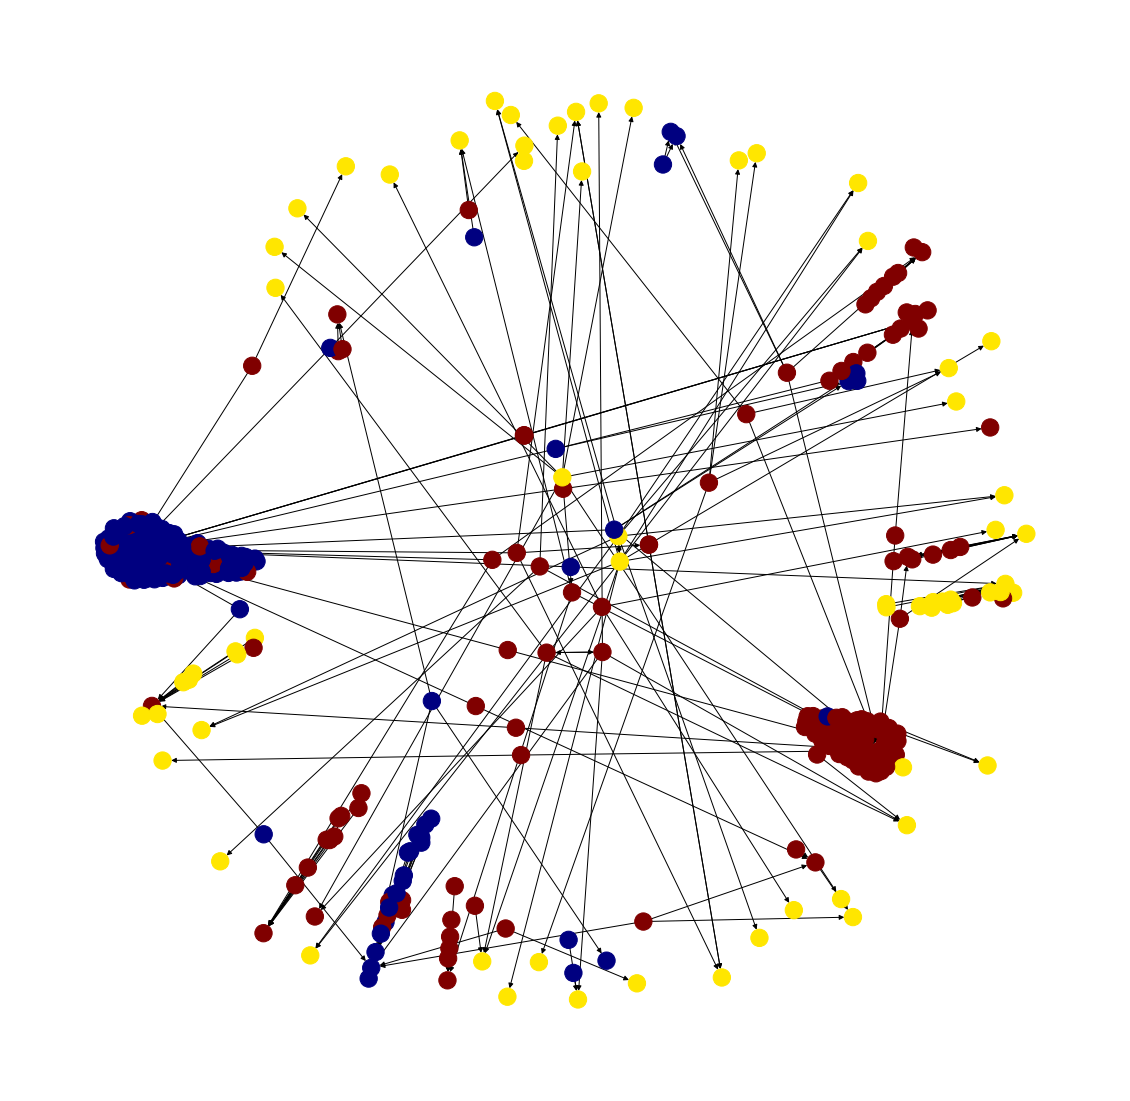

<----- class 15 ----->

<--- Modularity Class 15 Sorted by Eigenvector Centrality, top 10 values --->
Name: PrisonPlanet | Eigenvector Centrality: 0.00017317950637970269
Name: Sozzinski | Eigenvector Centrality: 3.08808628294599e-11
Name: swinny198 | Eigenvector Centrality: 3.08808628294599e-11
Name: Rockderk | Eigenvector Centrality: 2.3016462491797525e-12
Name: WaseemA21661632 | Eigenvector Centrality: 1.1508232617786995e-12
Name: gently_bimbling | Eigenvector Centrality: 1.1508232617786995e-12
Name: ChristianPost | Eigenvector Centrality: 1.2100054226980392e-16
Name: BlackBessDick | Eigenvector Centrality: 8.780084699849696e-17
Name: Lucas__Kane | Eigenvector Centrality: 7.572823053620365e-17
Name: MannaJewellery | Eigenvector Centrality: 7.572823053620365e-17


label  count
0      AGAINST    186
2  NOT_AGAINST     92
1         NONE     13

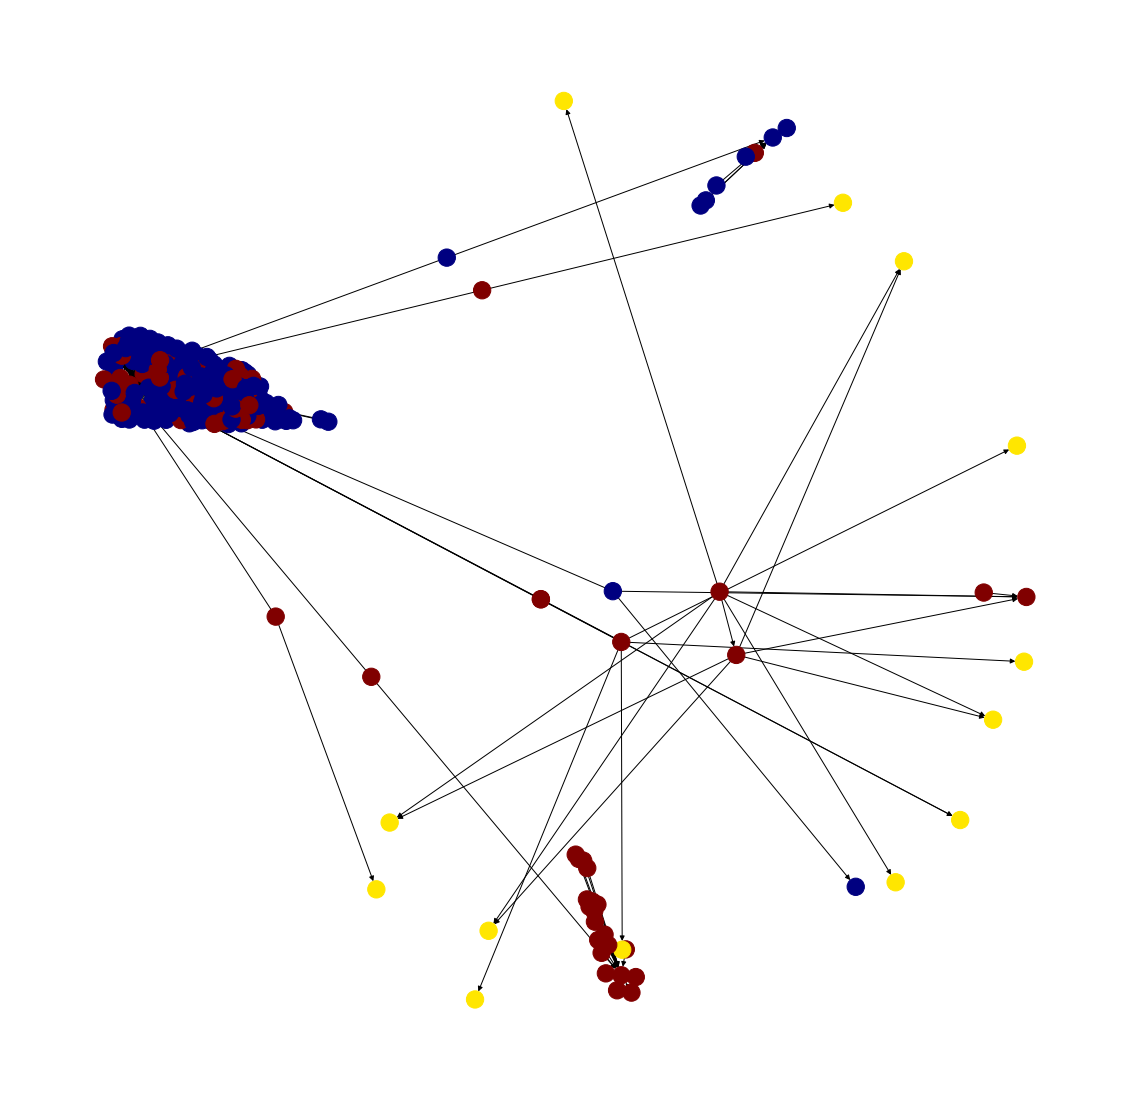

<----- class 18 ----->

<--- Modularity Class 18 Sorted by Eigenvector Centrality, top 10 values --->
Name: m_ontatta20 | Eigenvector Centrality: 8.69502762932017e-16
Name: Taehyung_india_ | Eigenvector Centrality: 1.4514577519439036e-16
Name: alsaad_fofo | Eigenvector Centrality: 2.7437764687030304e-19
Name: TashmiAmadi | Eigenvector Centrality: 2.7437764687030304e-19
Name: MuskanP25267761 | Eigenvector Centrality: 2.7437764687030304e-19
Name: Lily_stans_BTS | Eigenvector Centrality: 2.7437764687030304e-19
Name: BTSV_retwt | Eigenvector Centrality: 2.7437764687030304e-19
Name: ToTmmyy | Eigenvector Centrality: 2.7437764687030304e-19
Name: formyVmisun1230 | Eigenvector Centrality: 2.7437764687030304e-19
Name: TaeTae95778903 | Eigenvector Centrality: 2.7437764687030304e-19


label  count
0  AGAINST    165

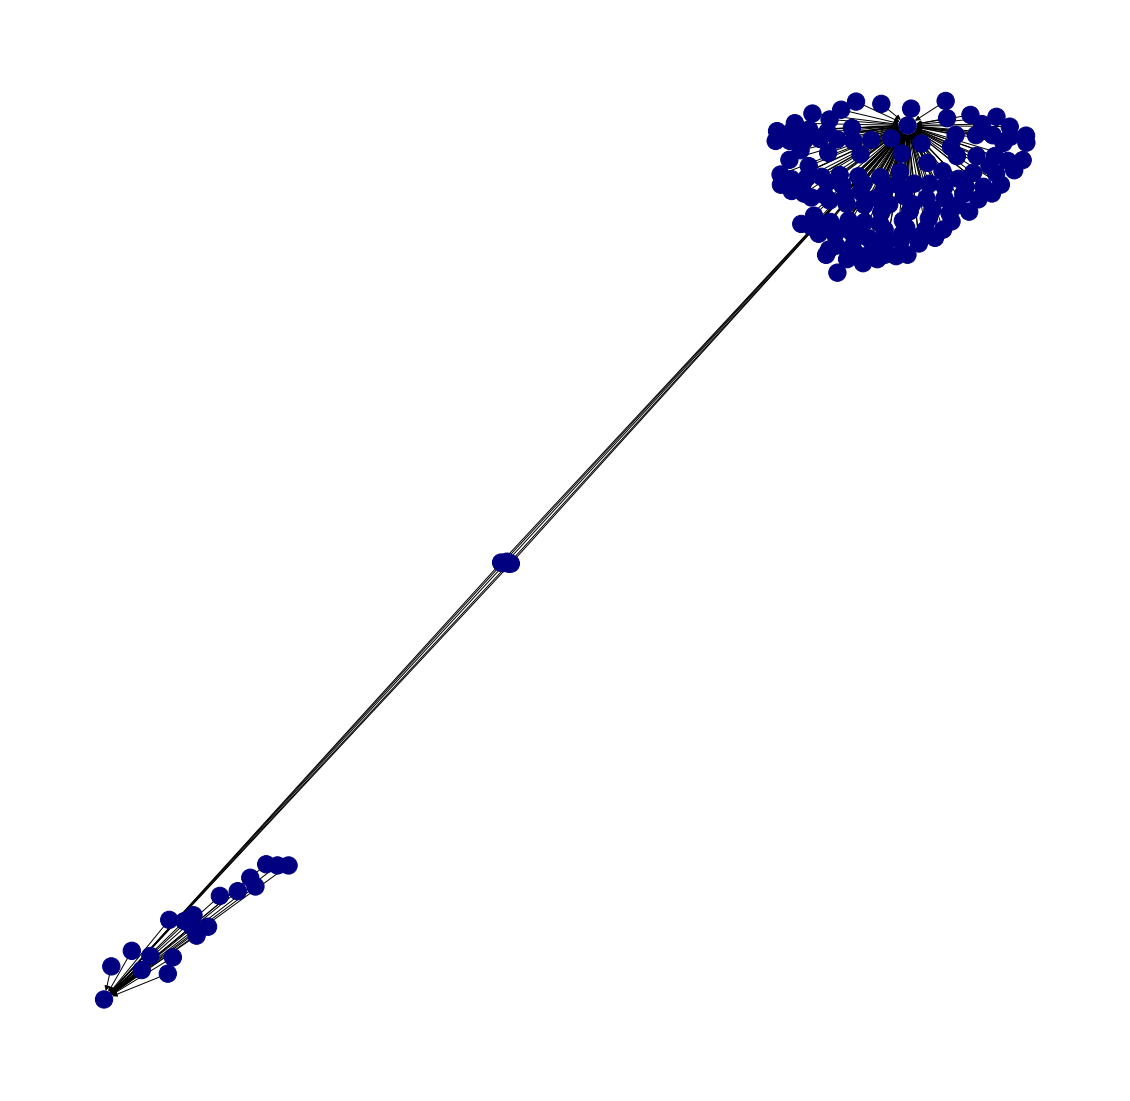

<----- class 6 ----->

<--- Modularity Class 6 Sorted by Eigenvector Centrality, top 10 values --->
Name: standardnews | Eigenvector Centrality: 0.00027673711533908826
Name: emilysheffield | Eigenvector Centrality: 8.344295315494183e-05
Name: martinpgriff | Eigenvector Centrality: 7.42734923304223e-05
Name: AlexAtherton100 | Eigenvector Centrality: 7.42734923304223e-05
Name: SteveChalke | Eigenvector Centrality: 7.42734923304223e-05
Name: cohenstandard | Eigenvector Centrality: 6.095401344612557e-05
Name: YouthEndowFund | Eigenvector Centrality: 5.6752386318134906e-05
Name: Eliza | Eigenvector Centrality: 5.6752386318134906e-05
Name: OneBigCommunity | Eigenvector Centrality: 5.648854979278644e-05
Name: HopeCollective2 | Eigenvector Centrality: 5.5771078379258425e-05


label  count
2  NOT_AGAINST    405
0      AGAINST    146
1         NONE    111

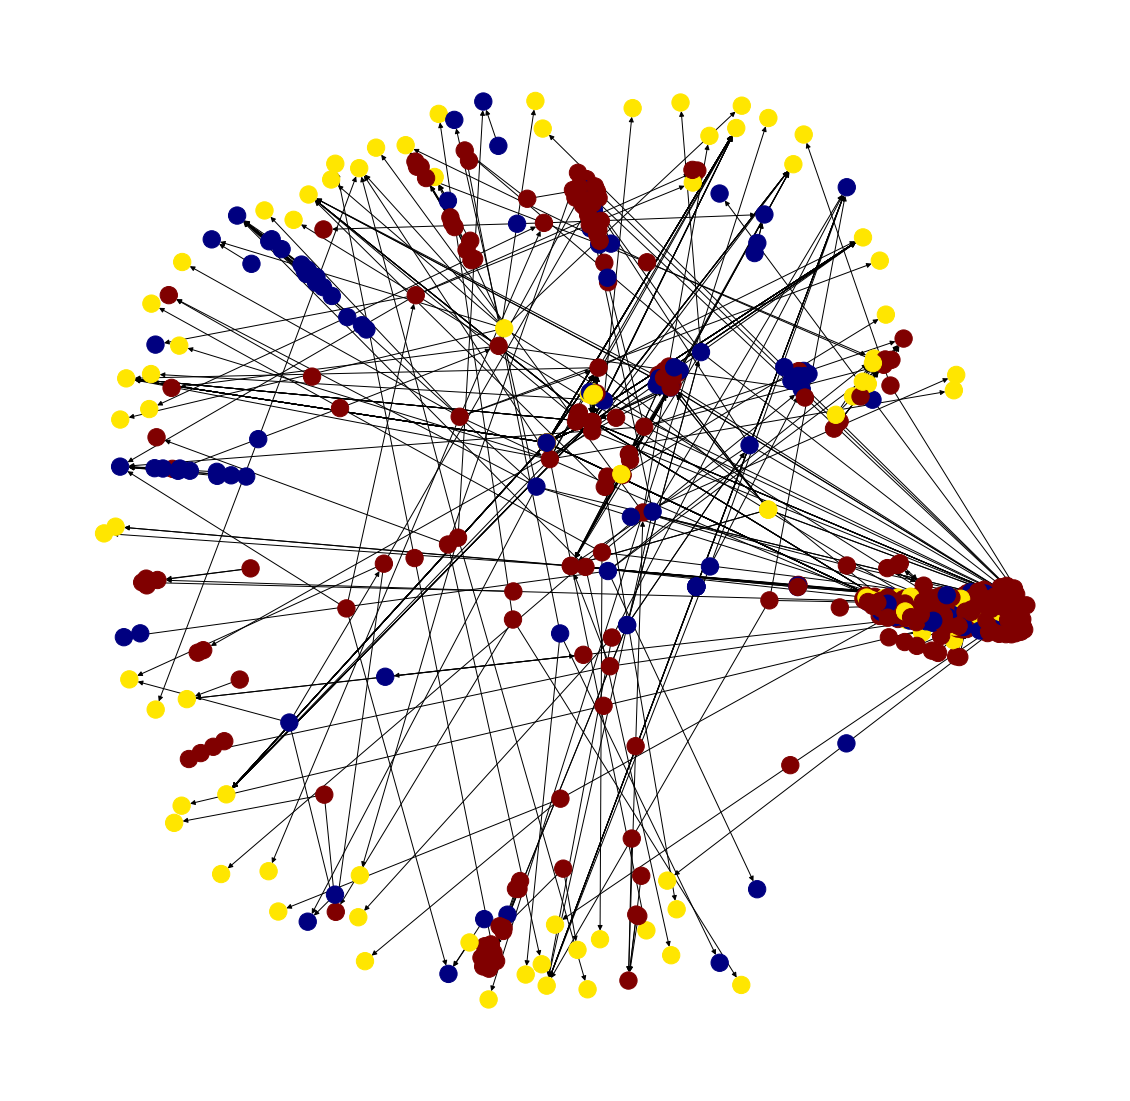

In [42]:
# now set colors
opinions = set(nx.get_node_attributes(G,'opinions').values())
mapping = dict(zip(sorted(opinions),count()))

class_list = [0, 1, 9, 5, 2, 13, 4, 11, 15, 18, 6]
top_member_count = 10

for class_id in class_list:
    print("<----- class {} ----->".format(class_id))
    print_class_members(class_id, top_member_count, mapping)


In [58]:
node_attributes = dict(G.nodes())
node_attribute_values = node_attributes.values()

node_attributes_df = pd.DataFrame(node_attribute_values,
                      columns =['name', 
                                'degree',
                                'betweenness',
                                'eigenvector',
                                'opinions',
                                'weak_component_id',
                                'modularity'])

print("Number of unique tweeters: {:,}".format(node_attributes_df['name'].count()))

node_attributes_df.rename(columns = {'modularity':'community_id'}, inplace = True)
node_attributes_df.rename(columns = {'name':'screen_name'}, inplace = True)
        
node_attributes_df.head()

Number of unique tweeters: 26,523


screen_name  degree   betweenness   eigenvector     opinions  \
0  myerschrismyer1       3  0.000000e+00  2.743776e-19  NOT_AGAINST   
1  LeslieH24367191     575  3.547568e-04  3.202488e-04  NOT_AGAINST   
2   emilysheffield      24  1.969320e-06  8.344295e-05  NOT_AGAINST   
3     NaheedMajeed       6  7.819276e-08  2.767187e-05  NOT_AGAINST   
4     standardnews     522  4.763550e-06  2.767371e-04  NOT_AGAINST   

   weak_component_id  community_id  
0                  0             0  
1                  0             0  
2                  0             6  
3                  0             6  
4                  0             6

In [71]:
grouped_community = node_attributes_df.groupby(['community_id', 'opinions']).agg({'screen_name': ['count']})
grouped_community.columns = ['count']
grouped_community = grouped_community.reset_index()
grouped_community = grouped_community[grouped_community.community_id.isin(class_list)]
grouped_community

community_id     opinions  count
0              0      AGAINST   2875
1              0          FOR      2
2              0         NONE    215
3              0  NOT_AGAINST   2121
4              1      AGAINST    690
5              1          FOR      1
6              1         NONE    582
7              1  NOT_AGAINST   2469
8              2      AGAINST    387
9              2         NONE    159
10             2  NOT_AGAINST   1078
14             4      AGAINST    242
15             4         NONE     99
16             4  NOT_AGAINST    670
17             5      AGAINST    409
18             5         NONE     96
19             5  NOT_AGAINST    277
20             6      AGAINST    146
21             6         NONE    111
22             6  NOT_AGAINST    405
29             9      AGAINST    451
30             9         NONE     13
31             9  NOT_AGAINST     56
35            11      AGAINST    194
36            11         NONE     67
37            11  NOT_AGAINST    187
41            13      AGAINST    261
42            13         NONE     21
43            13  NOT_AGAINST     77
47            15      AGAINST    186
48            15         NONE     13
49            15  NOT_AGAINST     92
56            18      AGAINST    165

In [72]:
community_list = [0,1,2,3,4,5,6]

grouped_weak_component = node_attributes_df.groupby(['weak_component_id', 'opinions']).agg({'screen_name': ['count']})
grouped_weak_component.columns = ['count']
grouped_weak_component = grouped_weak_component.reset_index()
grouped_weak_component = grouped_weak_component[grouped_weak_component.weak_component_id.isin(community_list)]
grouped_weak_component

weak_component_id     opinions  count
0                   0      AGAINST   7127
1                   0          FOR      4
2                   0         NONE   2578
3                   0  NOT_AGAINST  11092
4                   1      AGAINST    165
5                   2      AGAINST     17
6                   2         NONE     11
7                   2  NOT_AGAINST    135
8                   3         NONE      3
9                   3  NOT_AGAINST    122
10                  4      AGAINST     20
11                  4         NONE     14
12                  4  NOT_AGAINST     49
13                  5      AGAINST     12
14                  5         NONE     16
15                  5  NOT_AGAINST     15
16                  6  NOT_AGAINST     41

In [62]:
node_attributes_df_agg = node_attributes_df.groupby('community_id').count().reset_index()
node_attributes_df_agg[['community_id', 'screen_name']][node_attributes_df_agg.community_id.isin(class_list)].head(12)

community_id  screen_name
0              0         5213
1              1         3742
2              2         1624
4              4         1011
5              5          782
6              6          662
9              9          520
11            11          448
13            13          359
15            15          291
18            18          165

In [43]:
df_community_just_against = df_community_dict[df_community_dict.class_id.isin(class_list)].copy()

df_community_just_against_sorted = df_community_just_against.groupby('class_id').count().reset_index()
df_community_just_against_sorted.head(20)

class_id  screen_name
0          0         5213
1          1         3742
2          2         1624
3          4         1011
4          5          782
5          6          662
6          9          520
7         11          448
8         13          359
9         15          291
10        18          165

In [44]:
sorted_merged = pd.merge(df_community_just_against_sorted, just_against_sorted, left_on='class_id', right_on='class_id')
sorted_merged['pct_of_class'] = sorted_merged['count'] / sorted_merged['screen_name']

sorted_merged.rename(columns = {'screen_name':'community_count', 
                                'count':'label_count', 
                                'class_pct_of_total':'class_as_pct_all_against_labels',
                                'pct_of_class':'label_as_pct_whole_class'}, inplace = True)

sorted_merged.sort_values(by=['label_as_pct_whole_class'], ascending=False).head(20)

class_id  community_count  label_count  class_as_pct_all_against_labels  \
10        18              165          165                         0.020368   
6          9              520          451                         0.055672   
8         13              359          261                         0.032218   
9         15              291          186                         0.022960   
0          0             5213         2875                         0.354894   
4          5              782          409                         0.050488   
7         11              448          194                         0.023948   
3          4             1011          242                         0.029873   
2          2             1624          387                         0.047772   
5          6              662          146                         0.018022   
1          1             3742          690                         0.085175   

    label_as_pct_whole_class  
10                  1.000000  
6                   0.867308  
8                   0.727019  
9                   0.639175  
0                   0.551506  
4                   0.523018  
7                   0.433036  
3                   0.239367  
2                   0.238300  
5                   0.220544  
1                   0.184393